In [41]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse

import src.cfg as cfg
import src.data as data
import src.models as models
import src.processing as processing
import src.filters as fltr
from src.viz import Plot


import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')
from mpl_toolkits.basemap import Basemap



In [12]:
lats = np.load('/Users/drigo/ITMO/disser/surrogate/data/meta/lats.npy', allow_pickle=True)
lons = np.load('/Users/drigo/ITMO/disser/surrogate/data/meta/lons.npy', allow_pickle=True)
def plot_map(data2d, step=None, lats=lats, lons=lons, vmin=0, vmax=1):
    m = Basemap(projection='npstere', boundinglat=60, lon_0=0, resolution='i')
    
    if step is not None:
        lats = lats[::step[0],::step[1]]
        lons = lons[::step[0],::step[1]]
        data2d = data2d[::step[0],::step[1]]
    xi, yi = m(lons, lats)
        
    # m.drawparallels(np.arange(-80.,81.,20.), linewidth=0.8)
    # m.drawmeridians(np.arange(-180.,181.,20.), linewidth=0.8)
    # Add Coastlines, States, and Country Boundaries
    # m.drawlsmask(land_color='c', ocean_color='w', lsmask=None)
    m.fillcontinents()
    m.drawmapboundary(fill_color='white')
    m.drawcountries()
    # cmp = cm.get_cmap('rainbow', 11)
    my_cmap = plt.get_cmap('RdBu_r')
    my_cmap.set_bad('white')
    m.pcolormesh(xi, yi, data2d, cmap=my_cmap, vmin=vmin, vmax=vmax)
    m.colorbar()
def apply2dmask(array3d, mask2d):
    mask = np.broadcast_to(mask2d, array3d.shape)
    array3d[~mask]=np.nan
    res = array3d
    return res

In [34]:
#step=[1,1]

ice_sat = data.load_variable_years('thick_cr2smos',[2013,2014])
ice_line = np.load('/Users/drigo/ITMO/disser/surrogate/data/meta/ice_mask.npy', allow_pickle=True)

#res = np.load('/Users/drigo/ITMO/disser/surrogate/data/processed/res_1222_0754_comp.npy')
NEMO = data.load_variable_years('icethic_cea', [2013, 2014])
NEMO_LASSO = data.load_variable_years('icethic_cea_LASSO', [2013, 2014])
TOPAZ = data.load_variable_years('hice', [2013, 2014])


#res = apply2dmask(res, ice_line)
ice_sat = apply2dmask(ice_sat, ice_line)
NEMO = apply2dmask(NEMO, ice_line)
NEMO_LASSO = apply2dmask(NEMO_LASSO, ice_line)
TOPAZ = apply2dmask(TOPAZ, ice_line)

dates = pd.date_range('01/01/2013', '31/12/2014',freq='D')

Text(0.5, 1.0, 'Data-driven model: Mean sea-ice thickness in years 2013-2014, m')

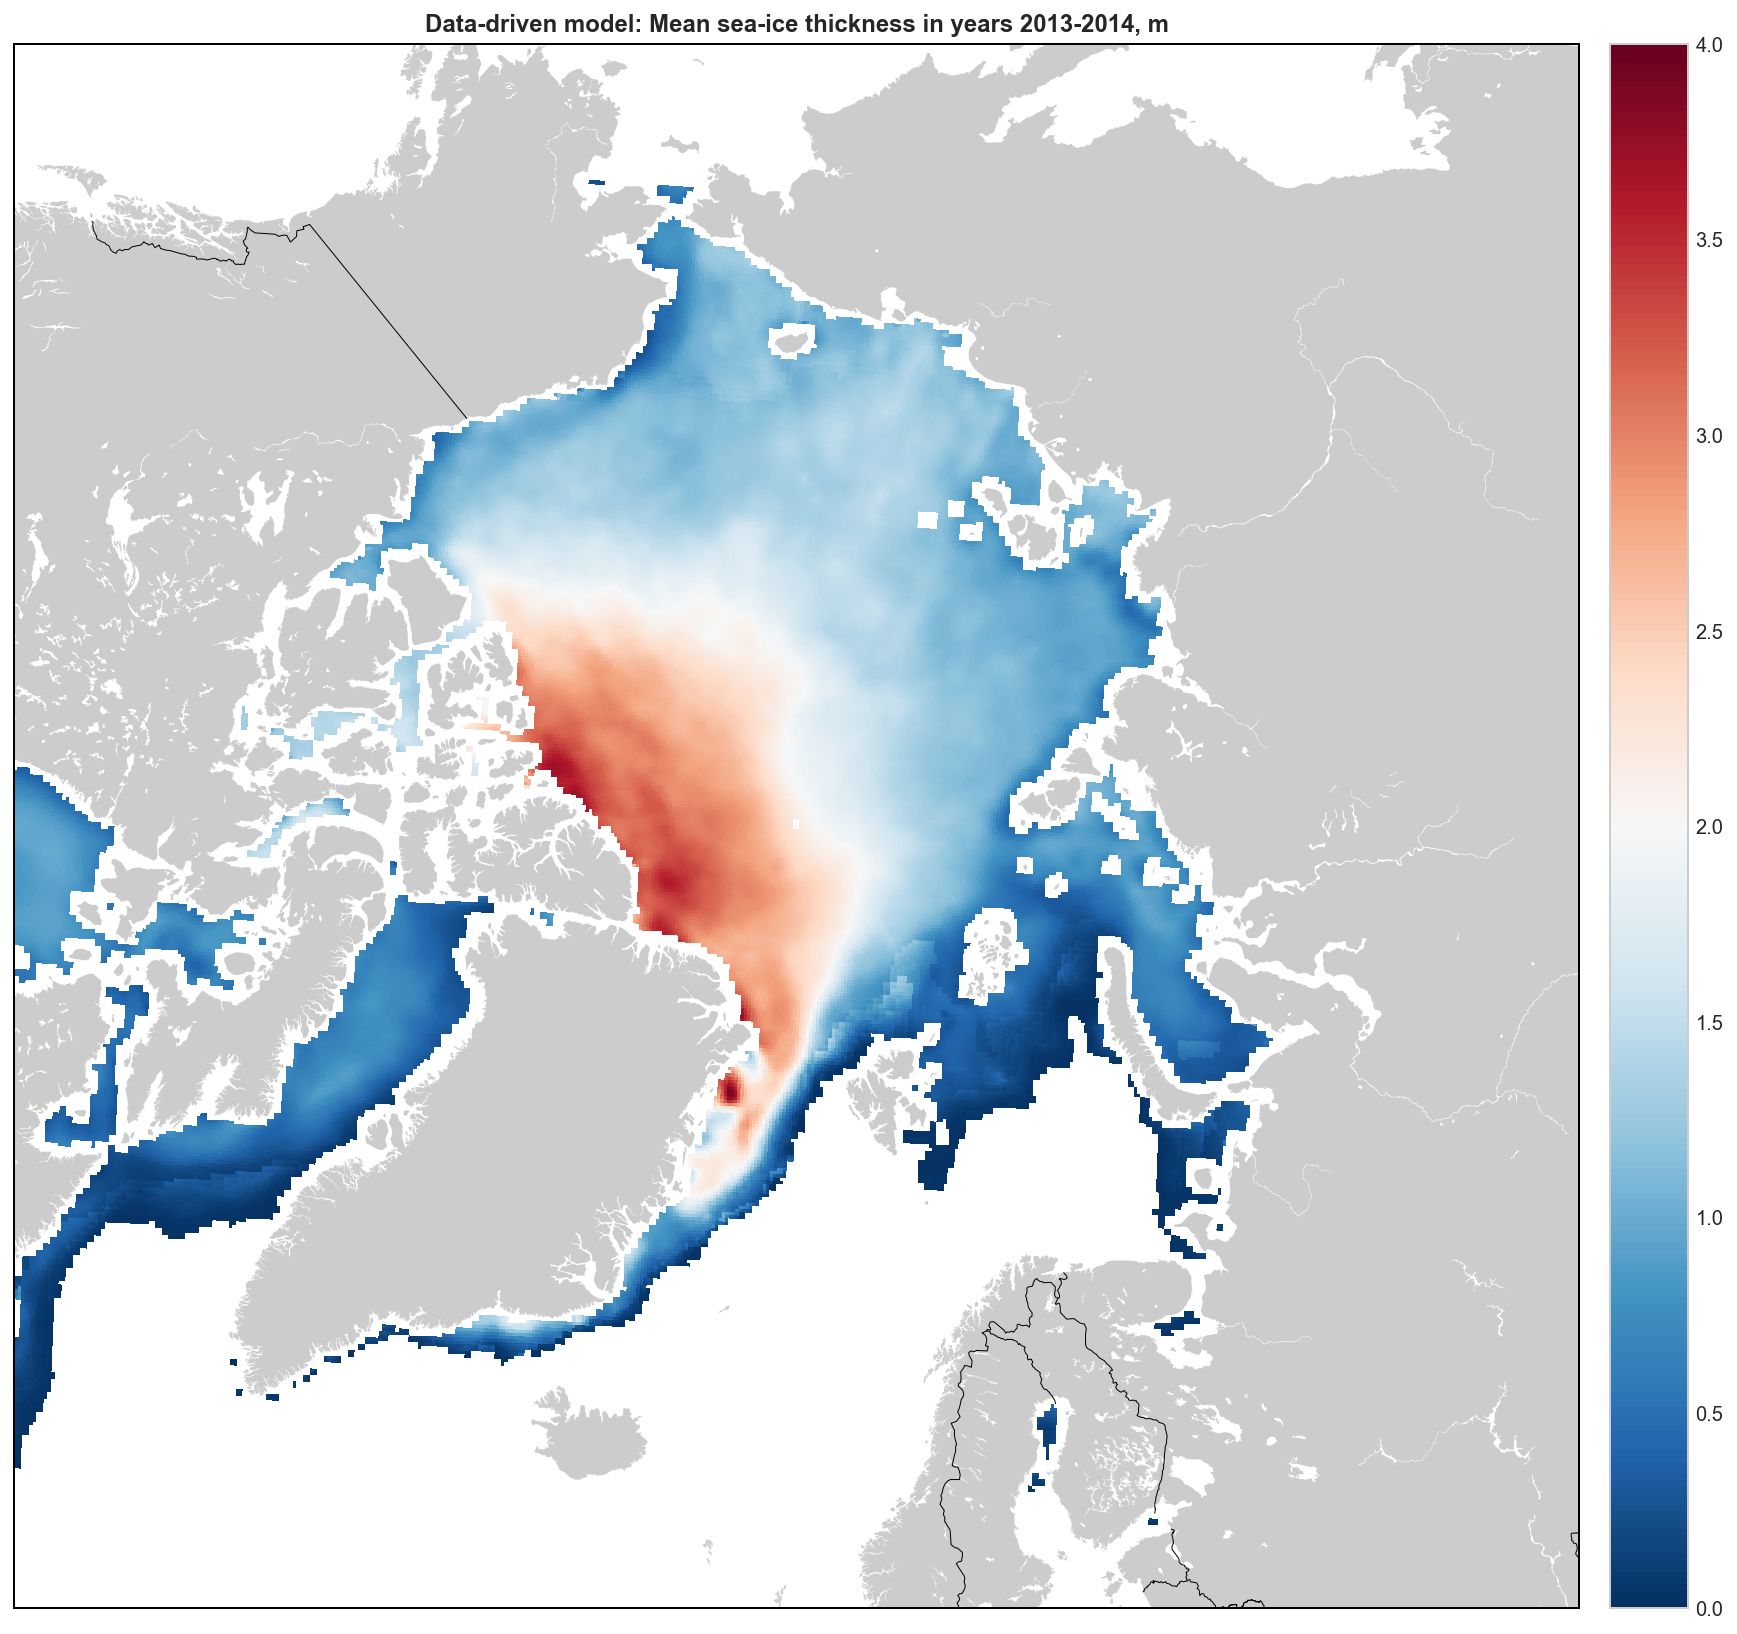

In [60]:
plot_map(np.nanmean(ice_sat, axis=0), vmin=0, vmax=4)
plt.title('Data-driven model: Mean sea-ice thickness in years 2013-2014, m', weight='bold')

In [63]:
salinity = data.load_variable_years('vosaline', [2013, 2014])


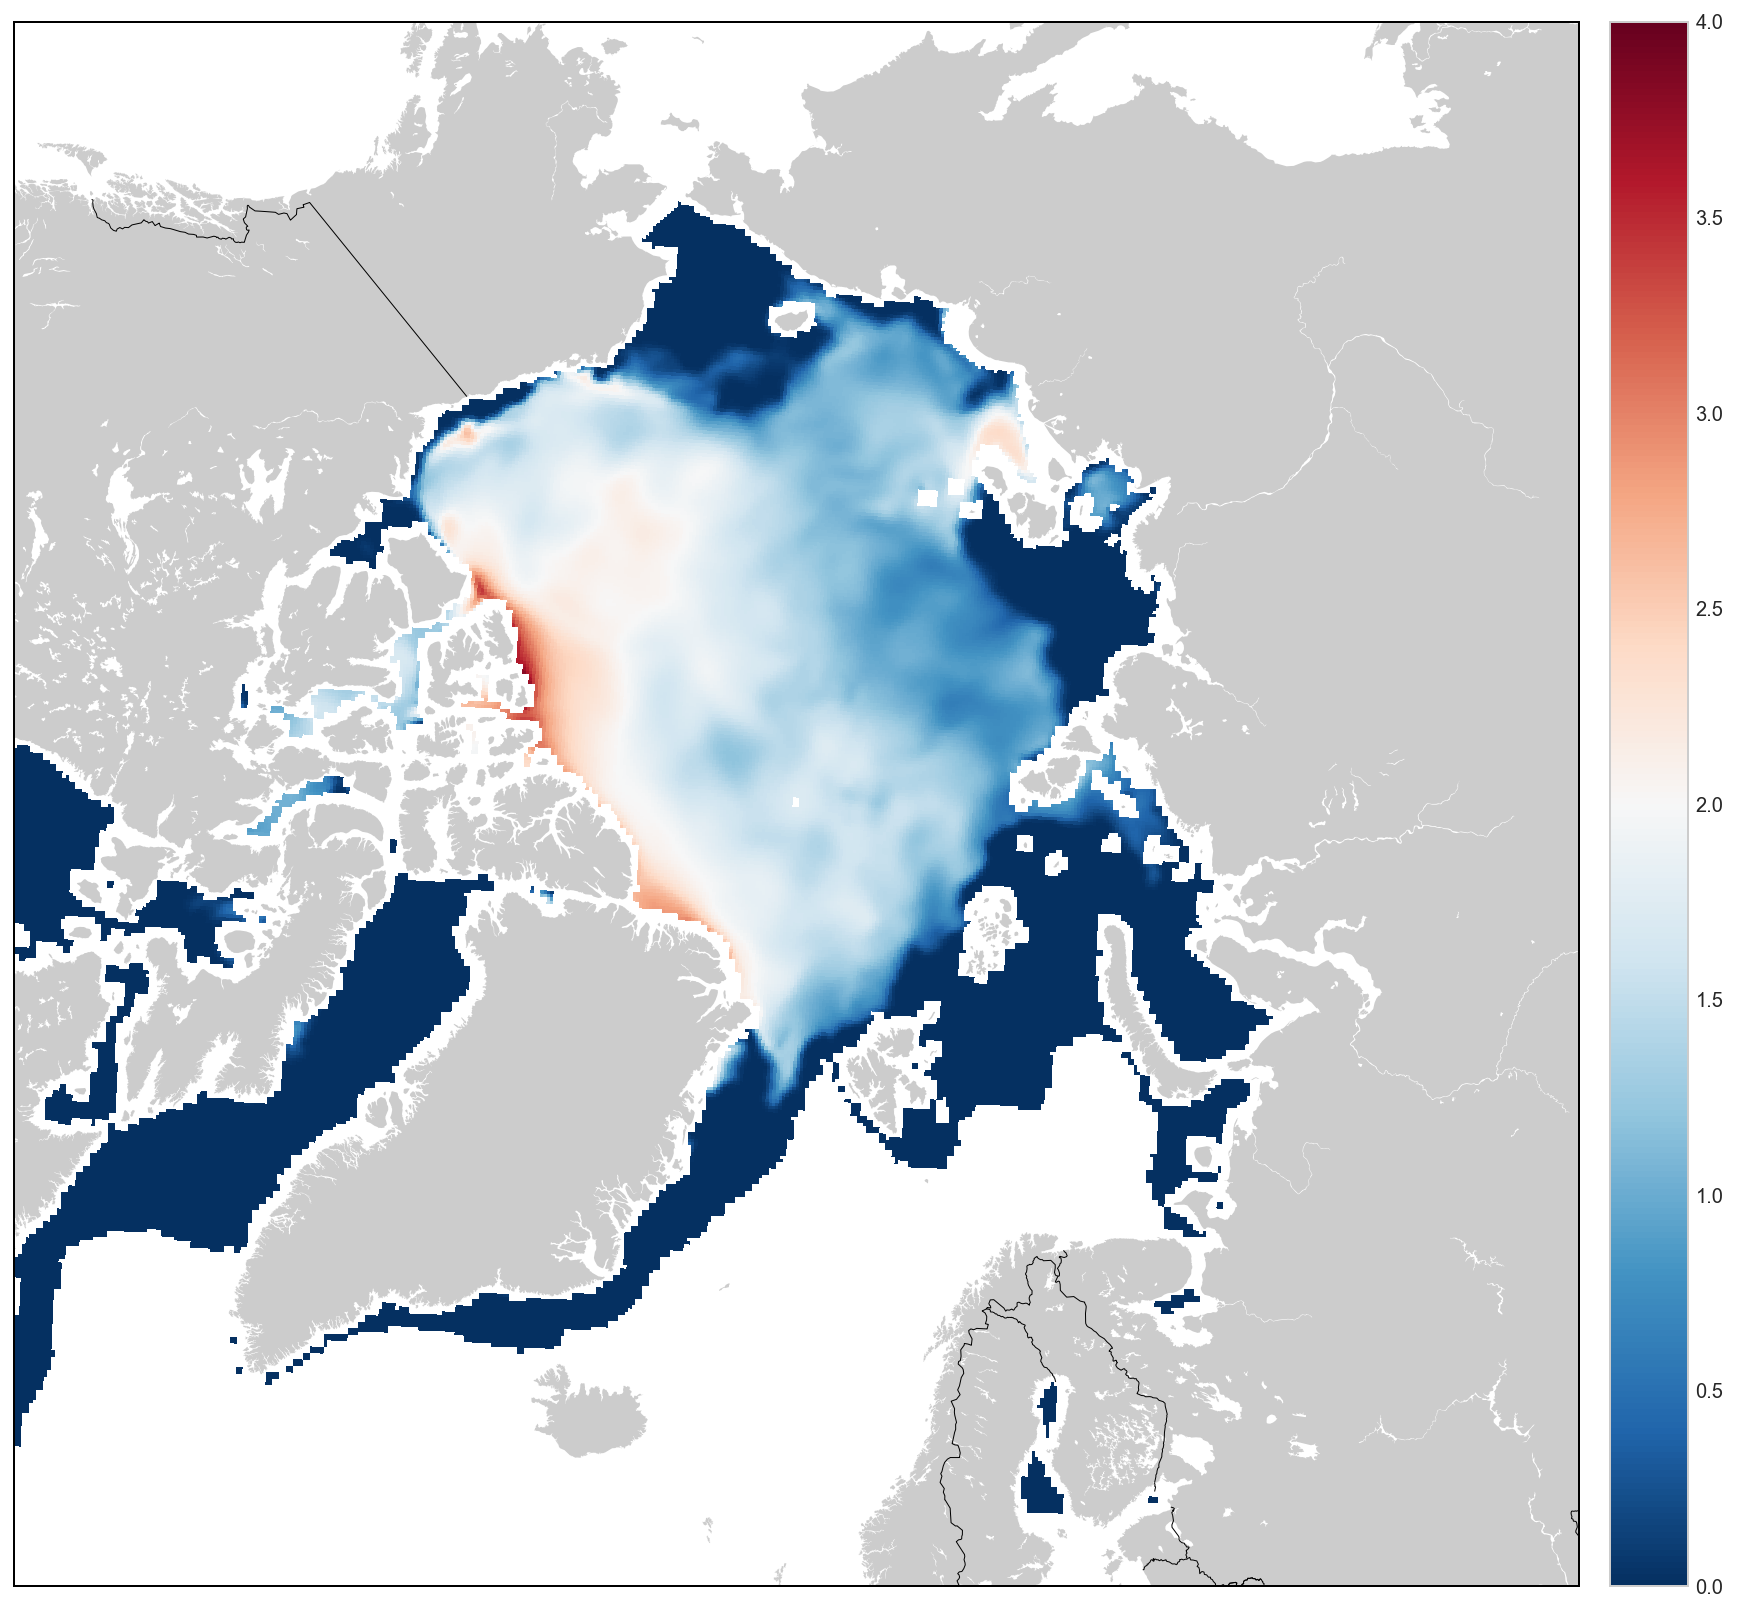

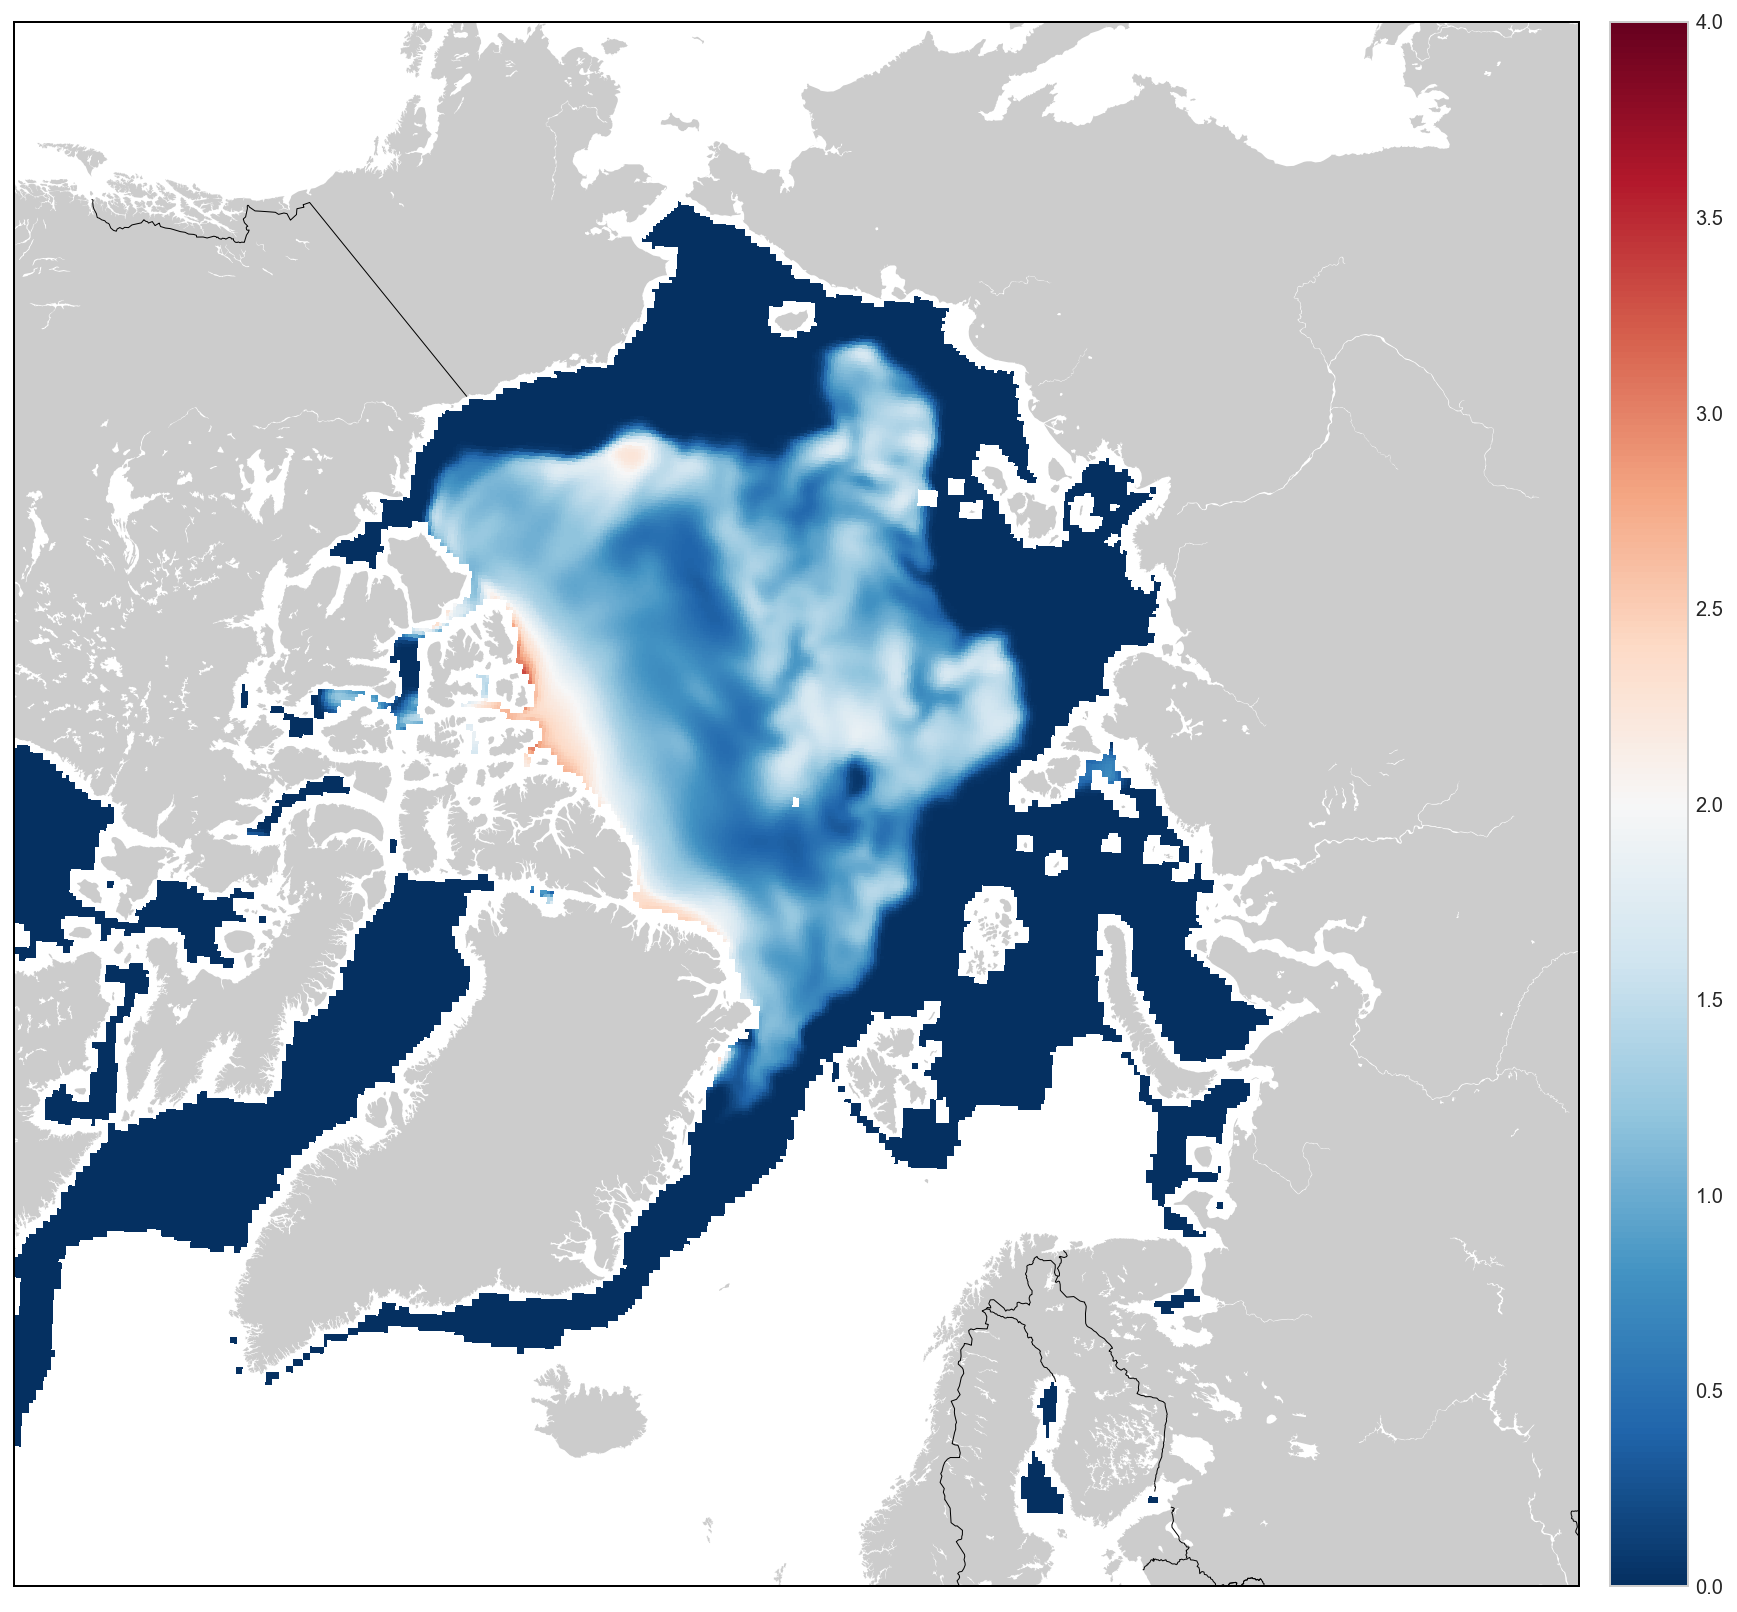

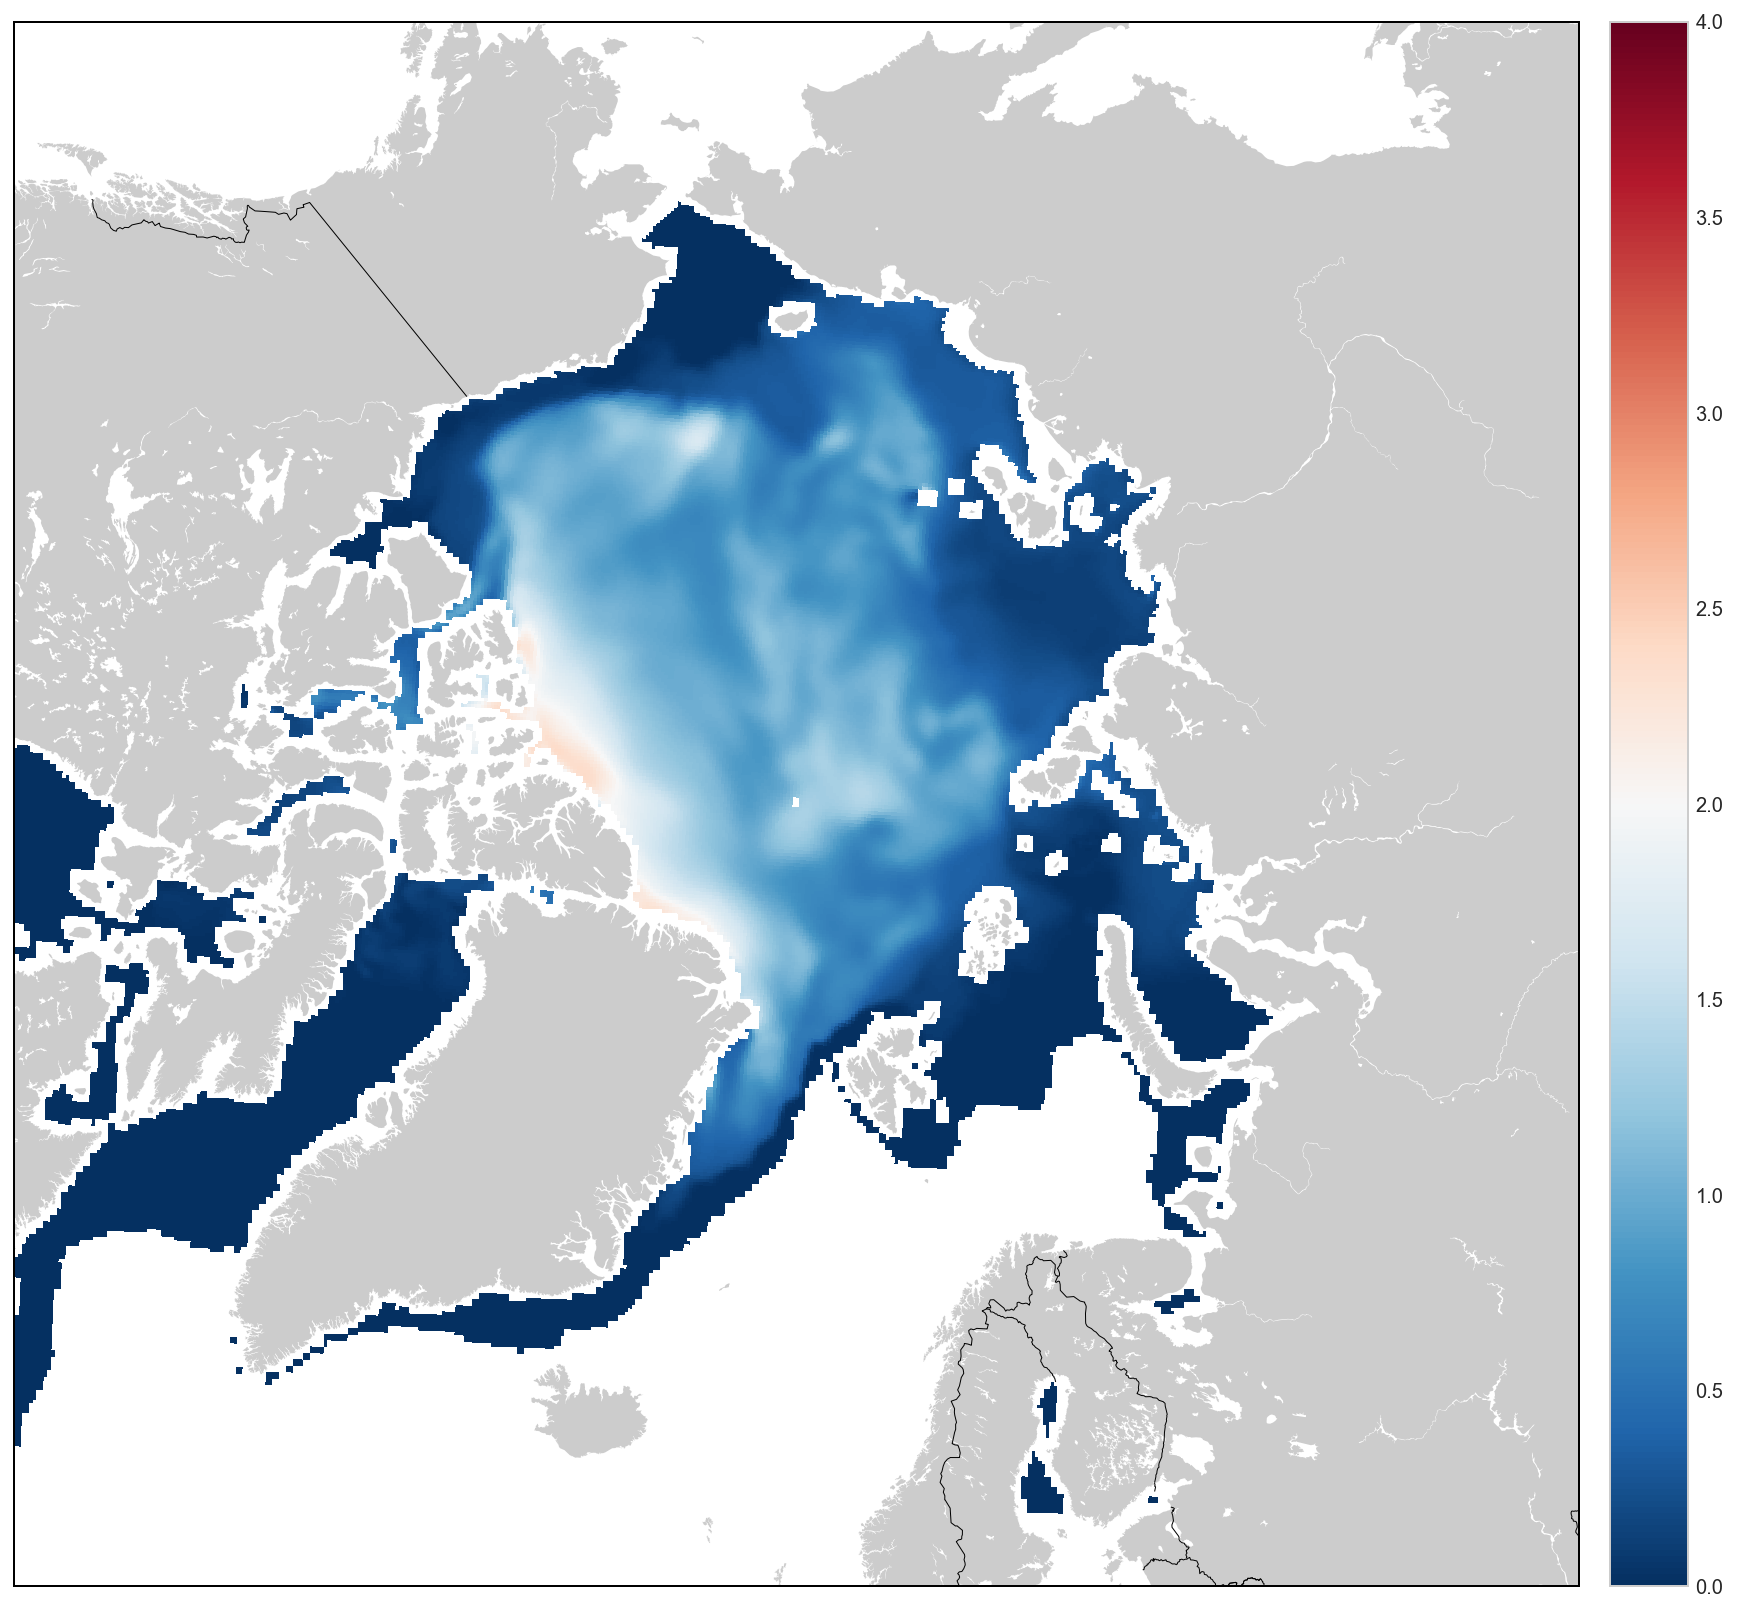

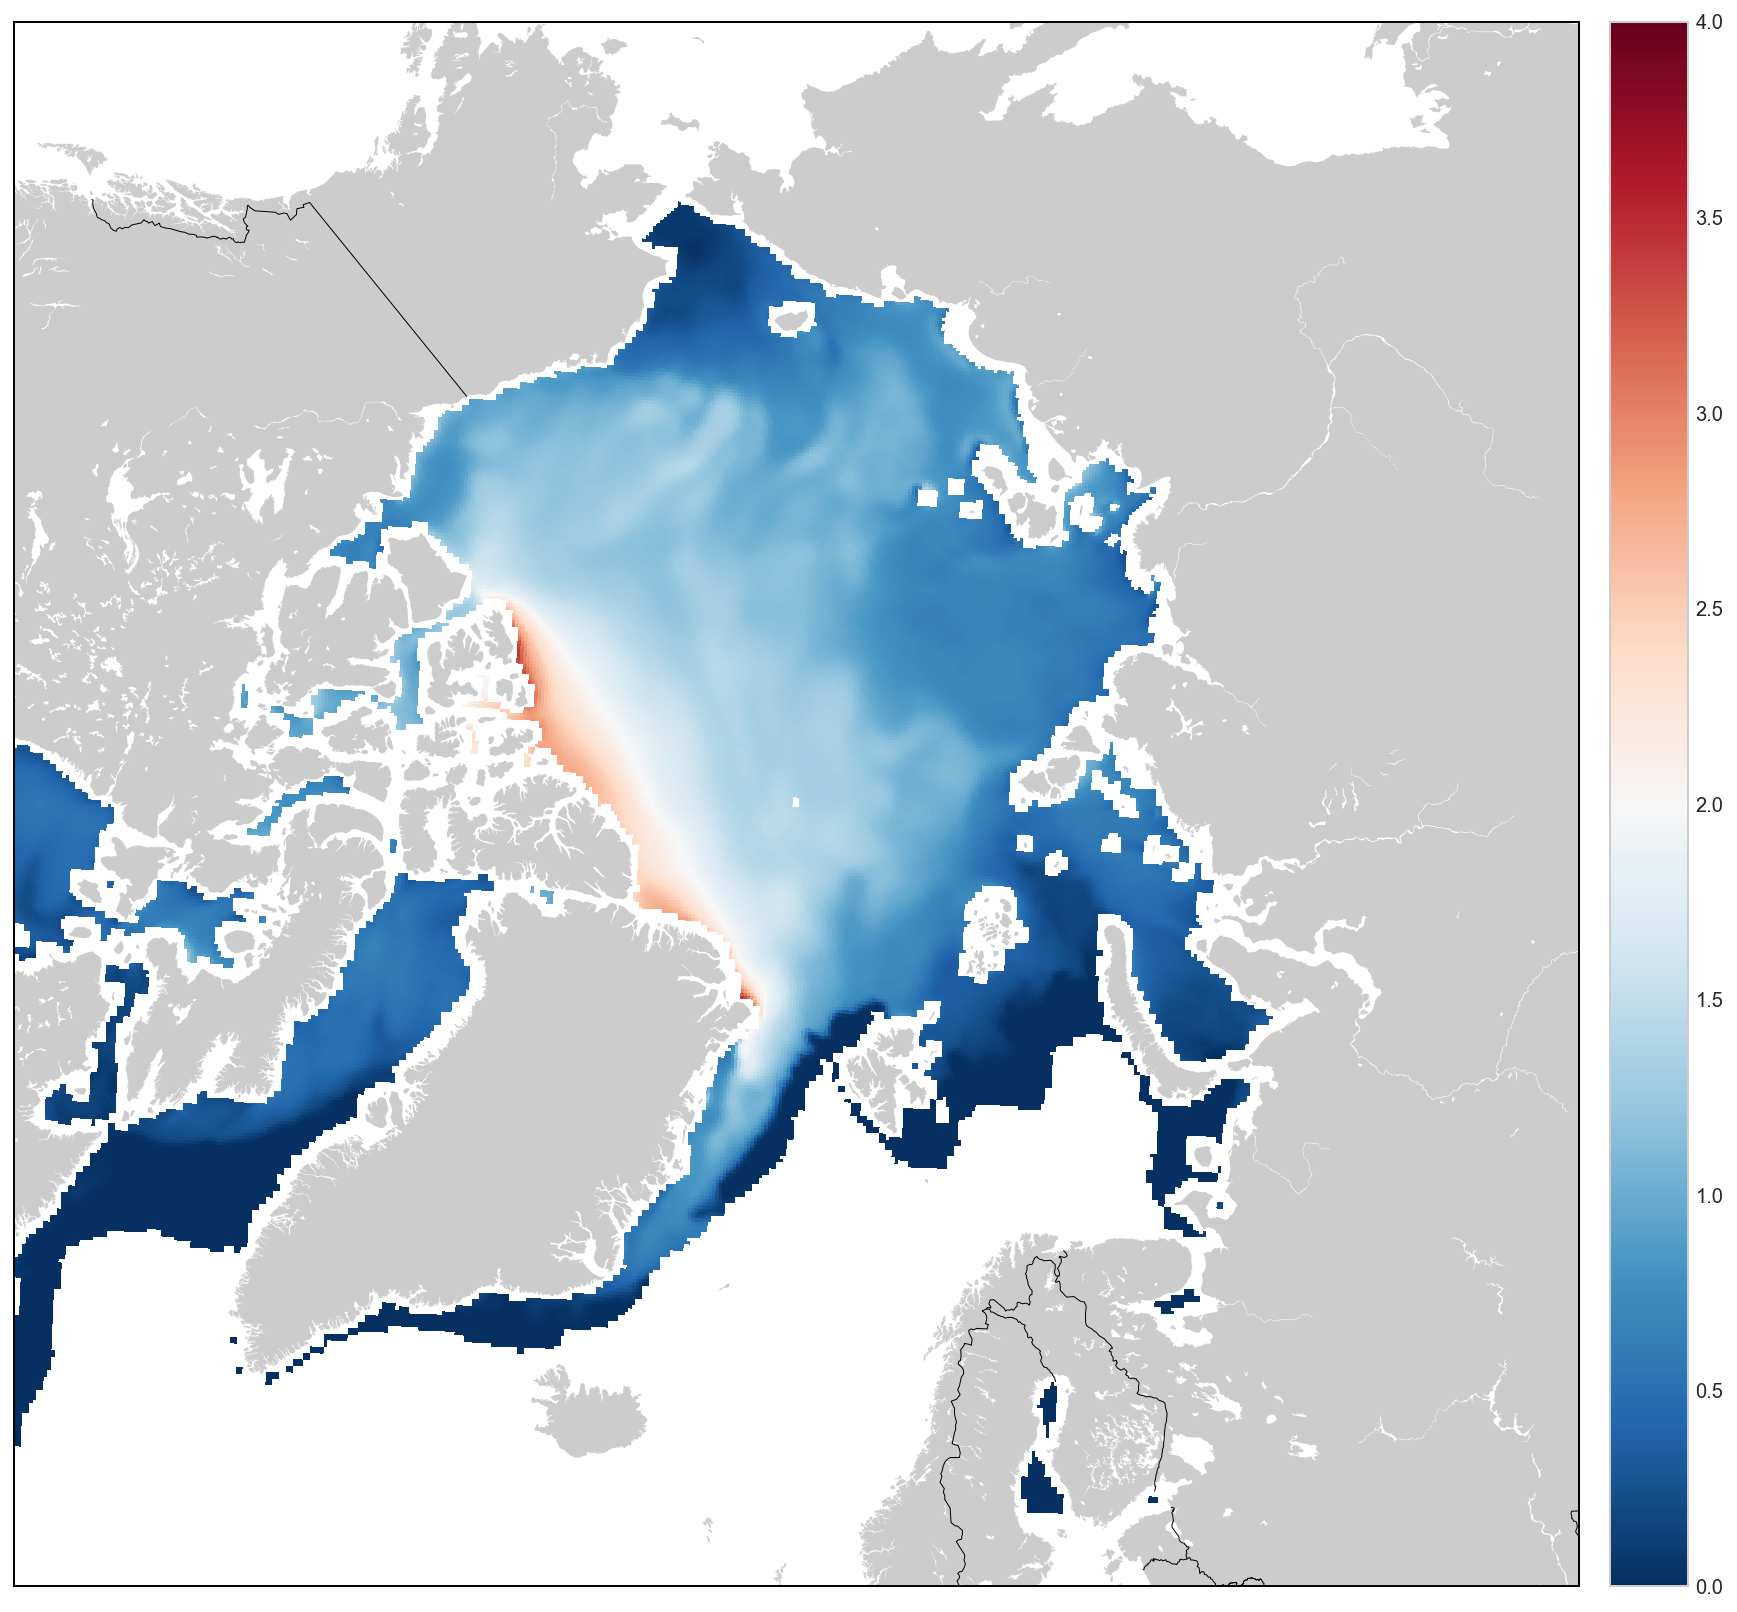

In [67]:
for i in range(200,400,50):
    plot_map(TOPAZ[i,:,:], vmin=0, vmax=4)
    plt.show()

Text(0.5, 1.0, 'NEMO: Mean sea-ice thickness in years 2013-2014, m')

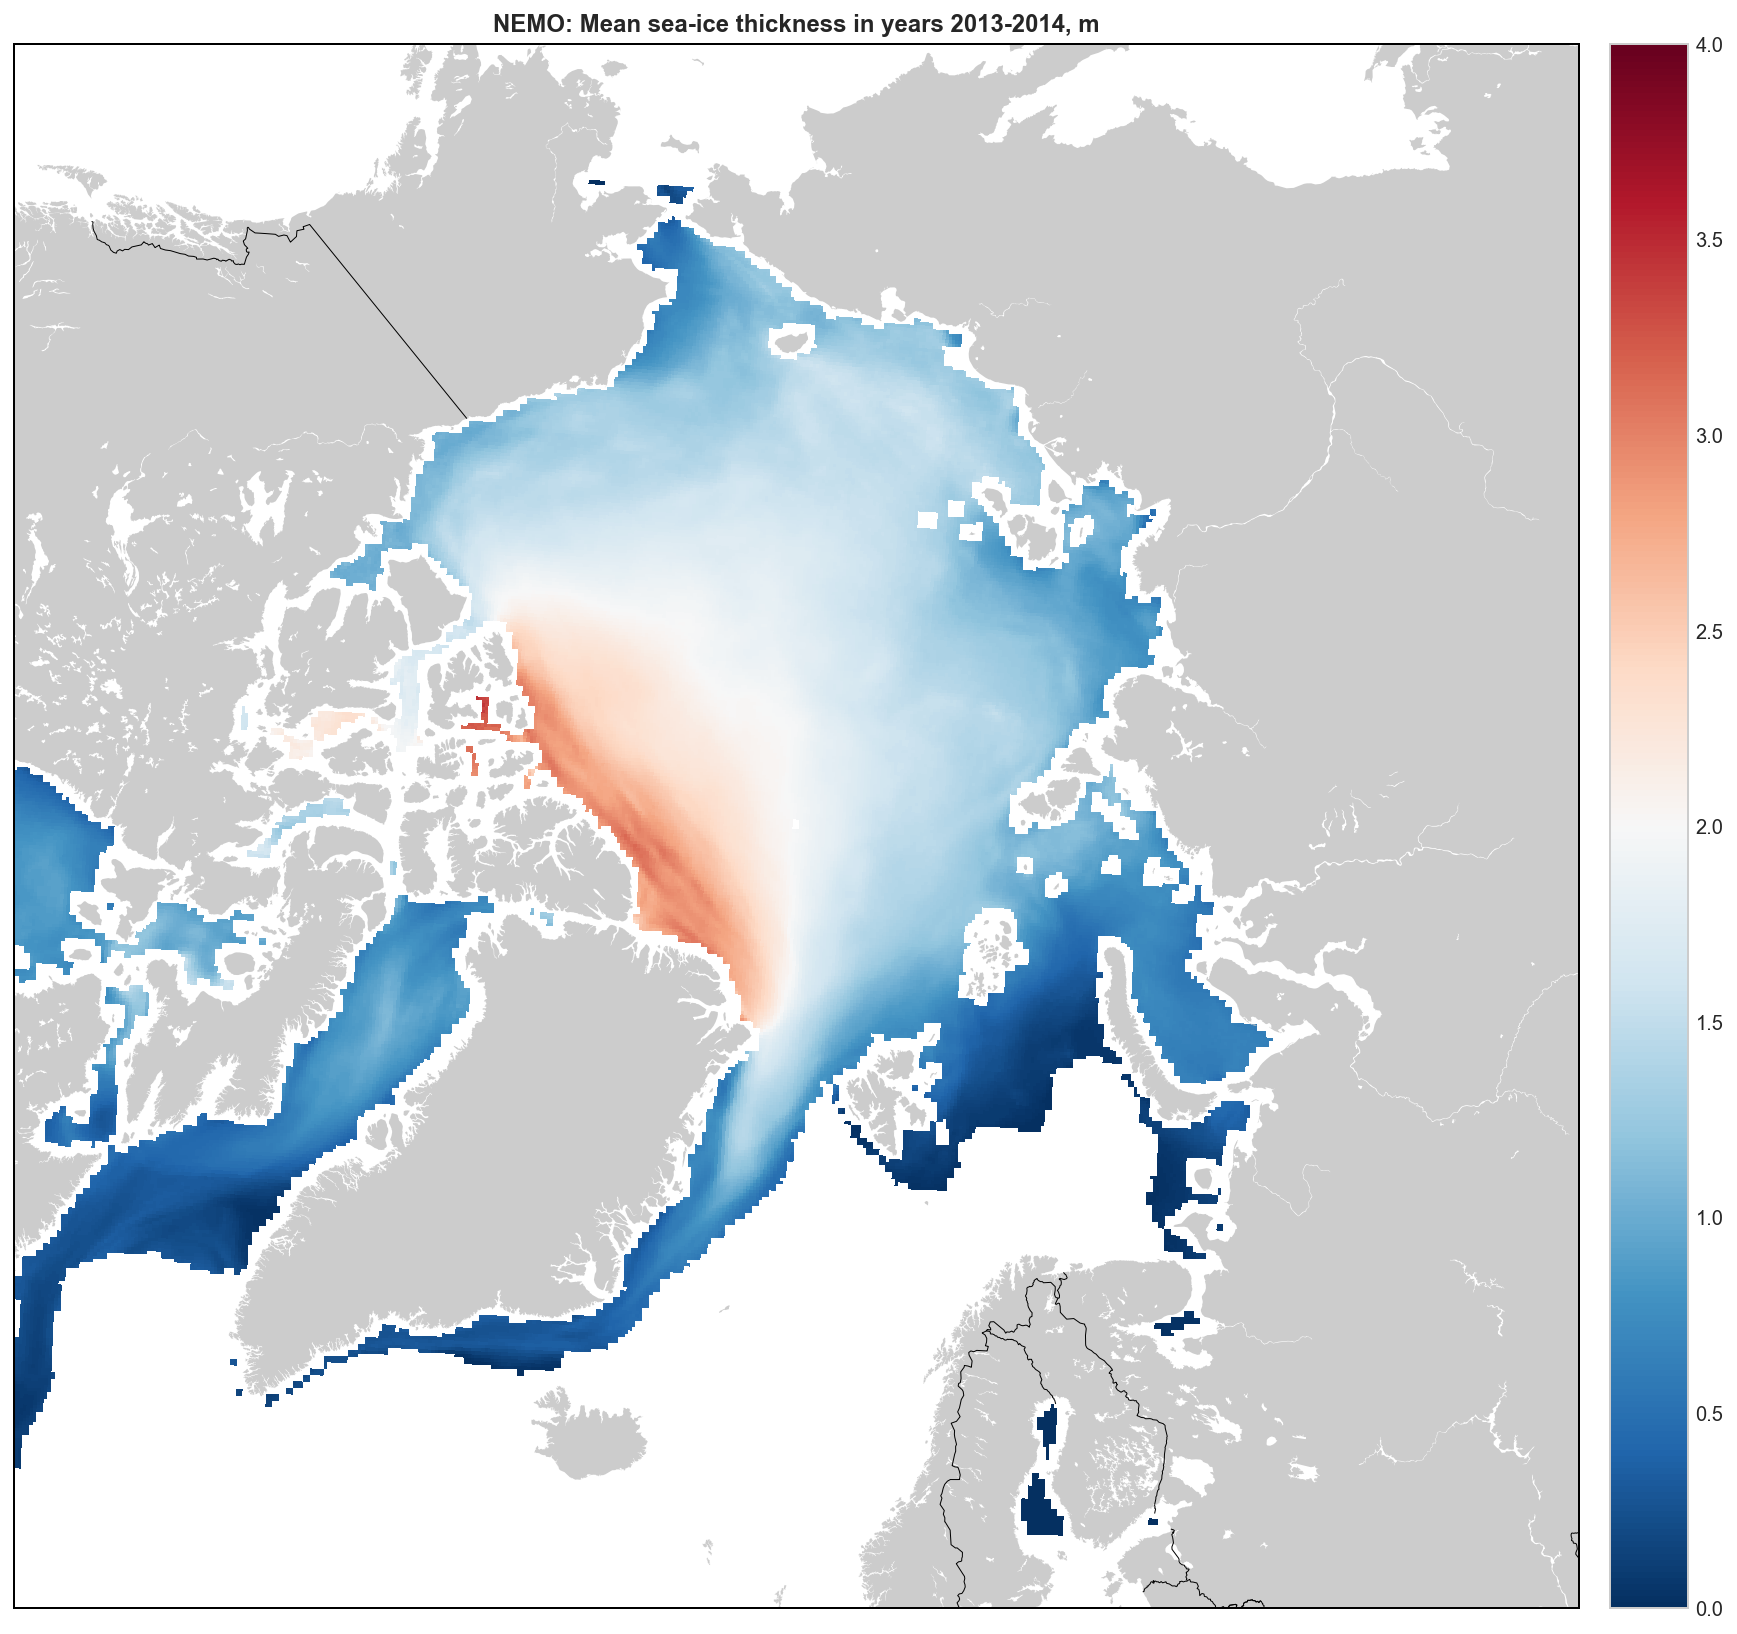

In [44]:
plot_map(np.nanmean(NEMO, axis=0), vmin=0, vmax=4)
plt.title('NEMO: Mean sea-ice thickness in years 2013-2014, m', weight='bold')

Text(0.5, 1.0, 'NEMO: Mean sea-ice thickness in years 2014-2015, m')

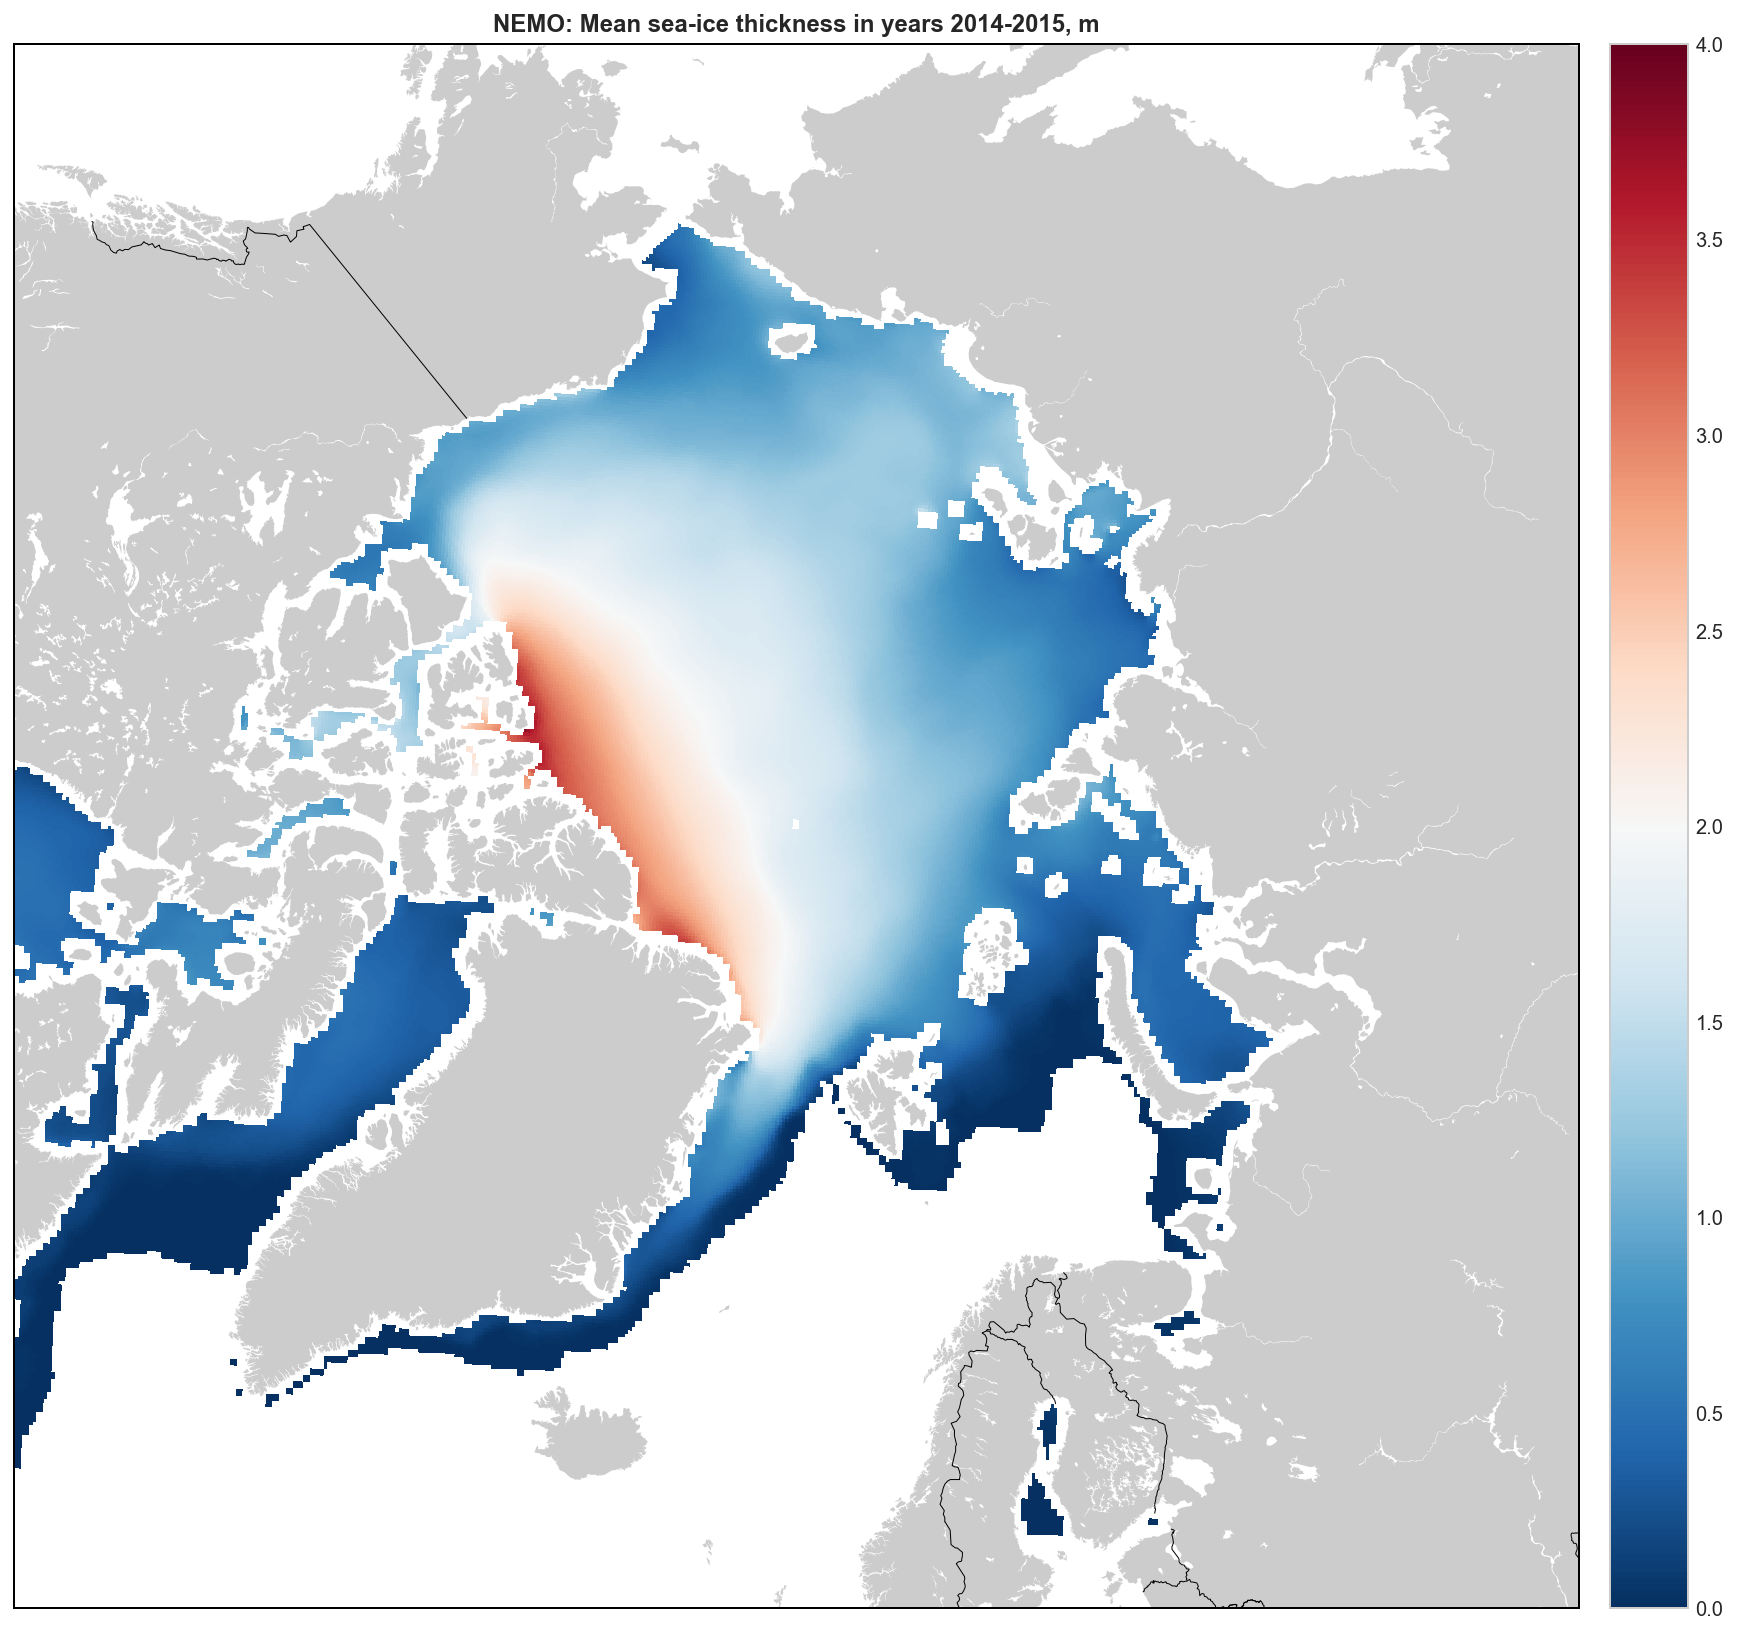

In [16]:
plot_map(np.nanmean(TOPAZ, axis=0), vmin=0, vmax=4)
plt.title('NEMO: Mean sea-ice thickness in years 2014-2015, m', weight='bold')

Text(0.5, 1.0, 'NEMO+LASSO: Mean sea-ice thickness in years 2013-2014, m')

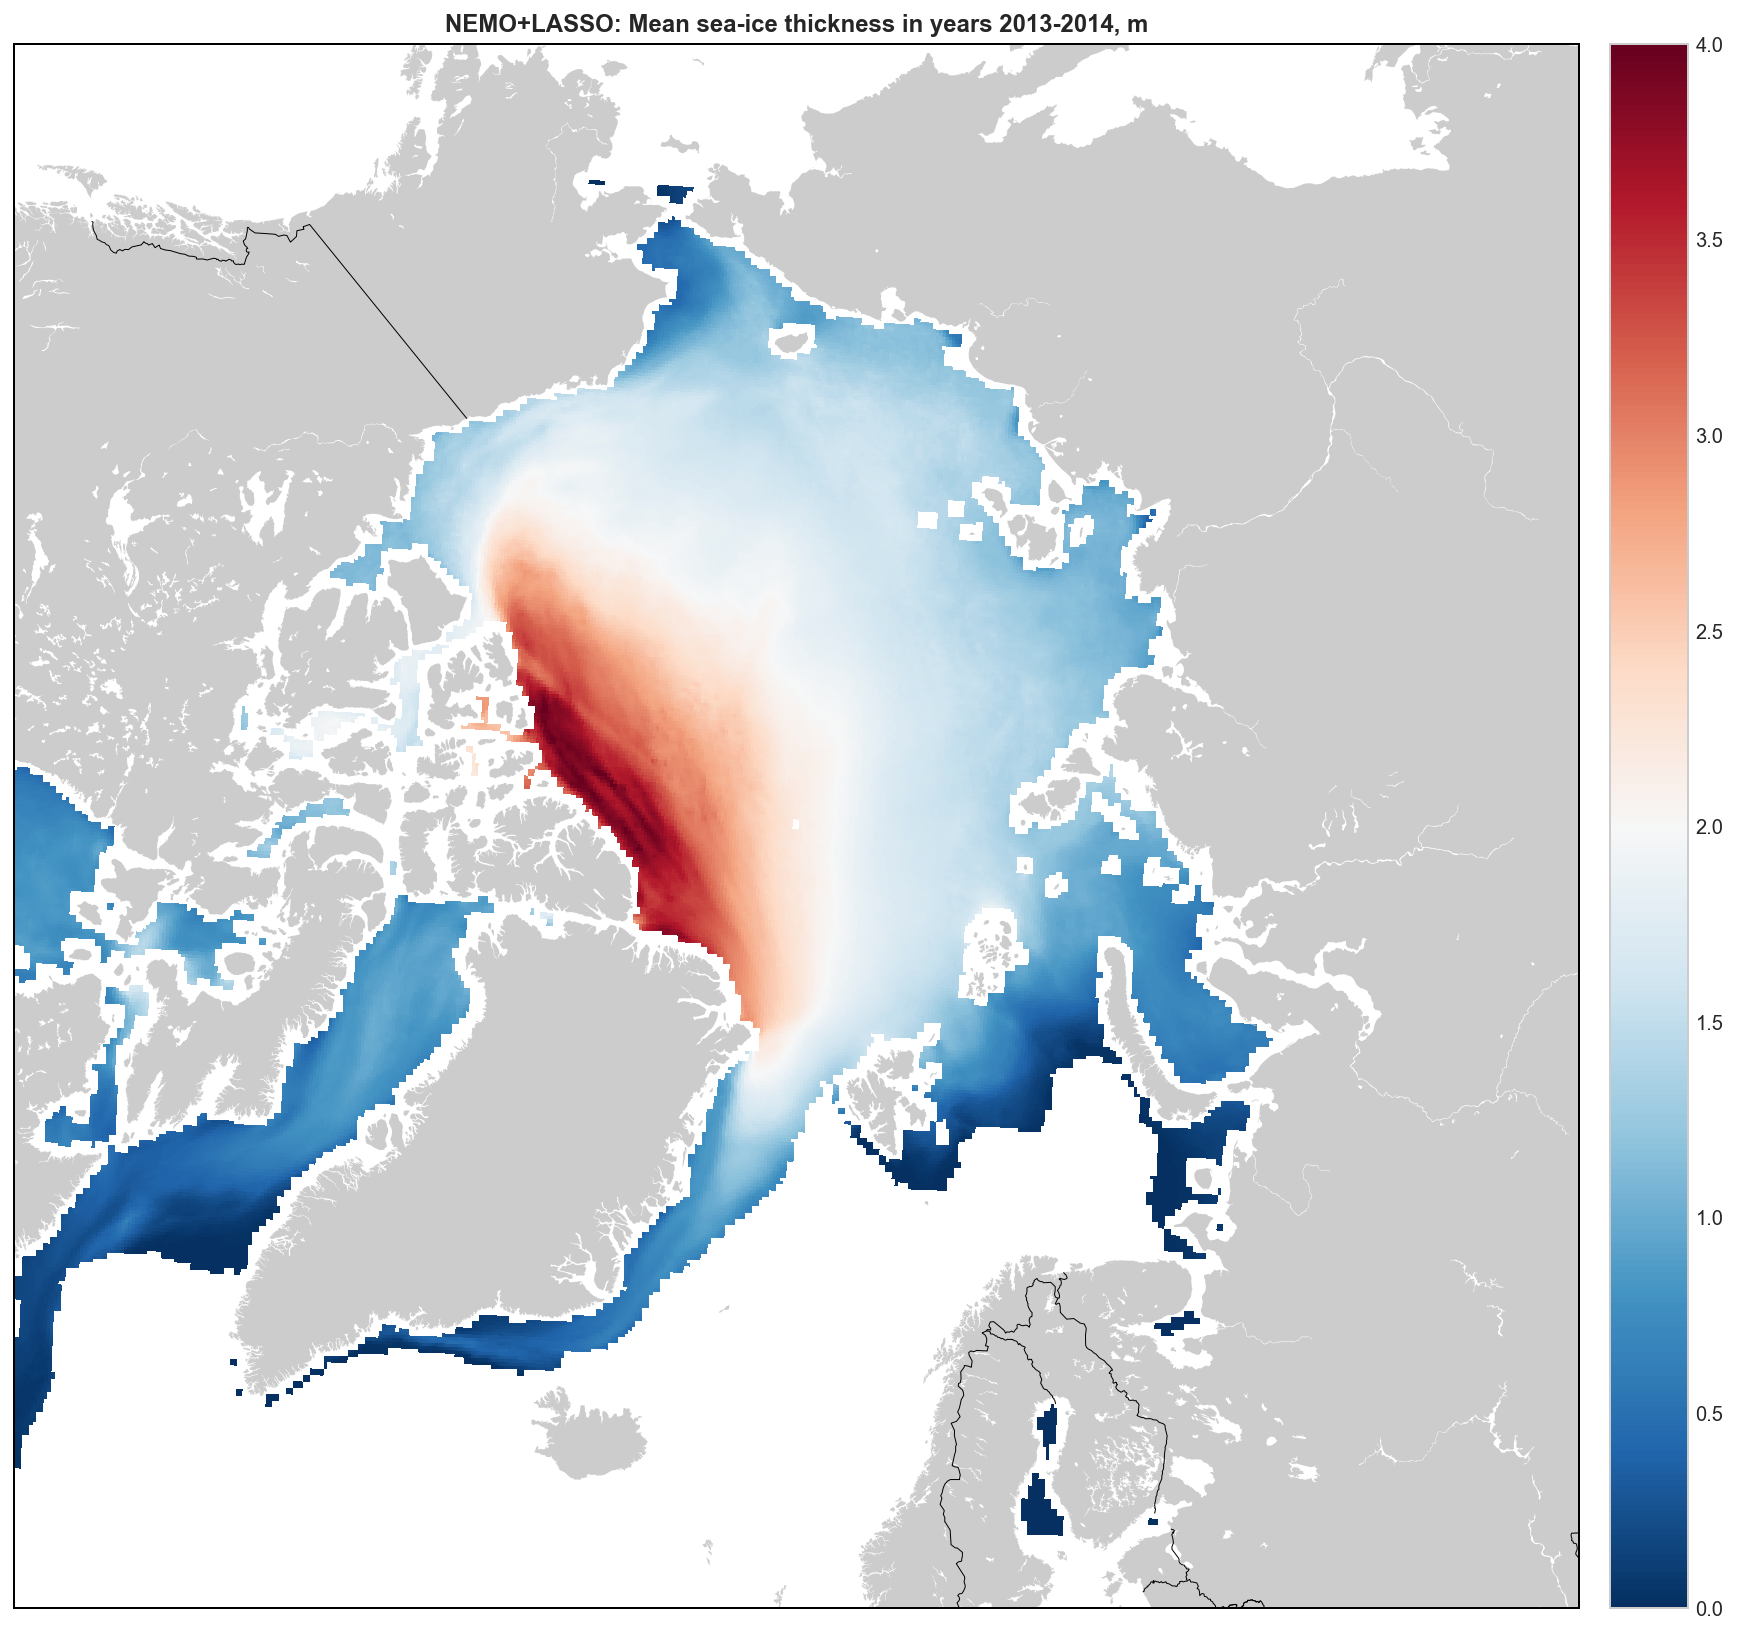

In [46]:
plot_map(np.nanmean(NEMO_LASSO, axis=0), vmin=0, vmax=4)
plt.title('NEMO+LASSO: Mean sea-ice thickness in years 2013-2014, m', weight='bold')

Text(0.5, 1.0, 'NEMO_LASSO - NEMO: Mean sea-ice thickness in years 2013-2014, m')

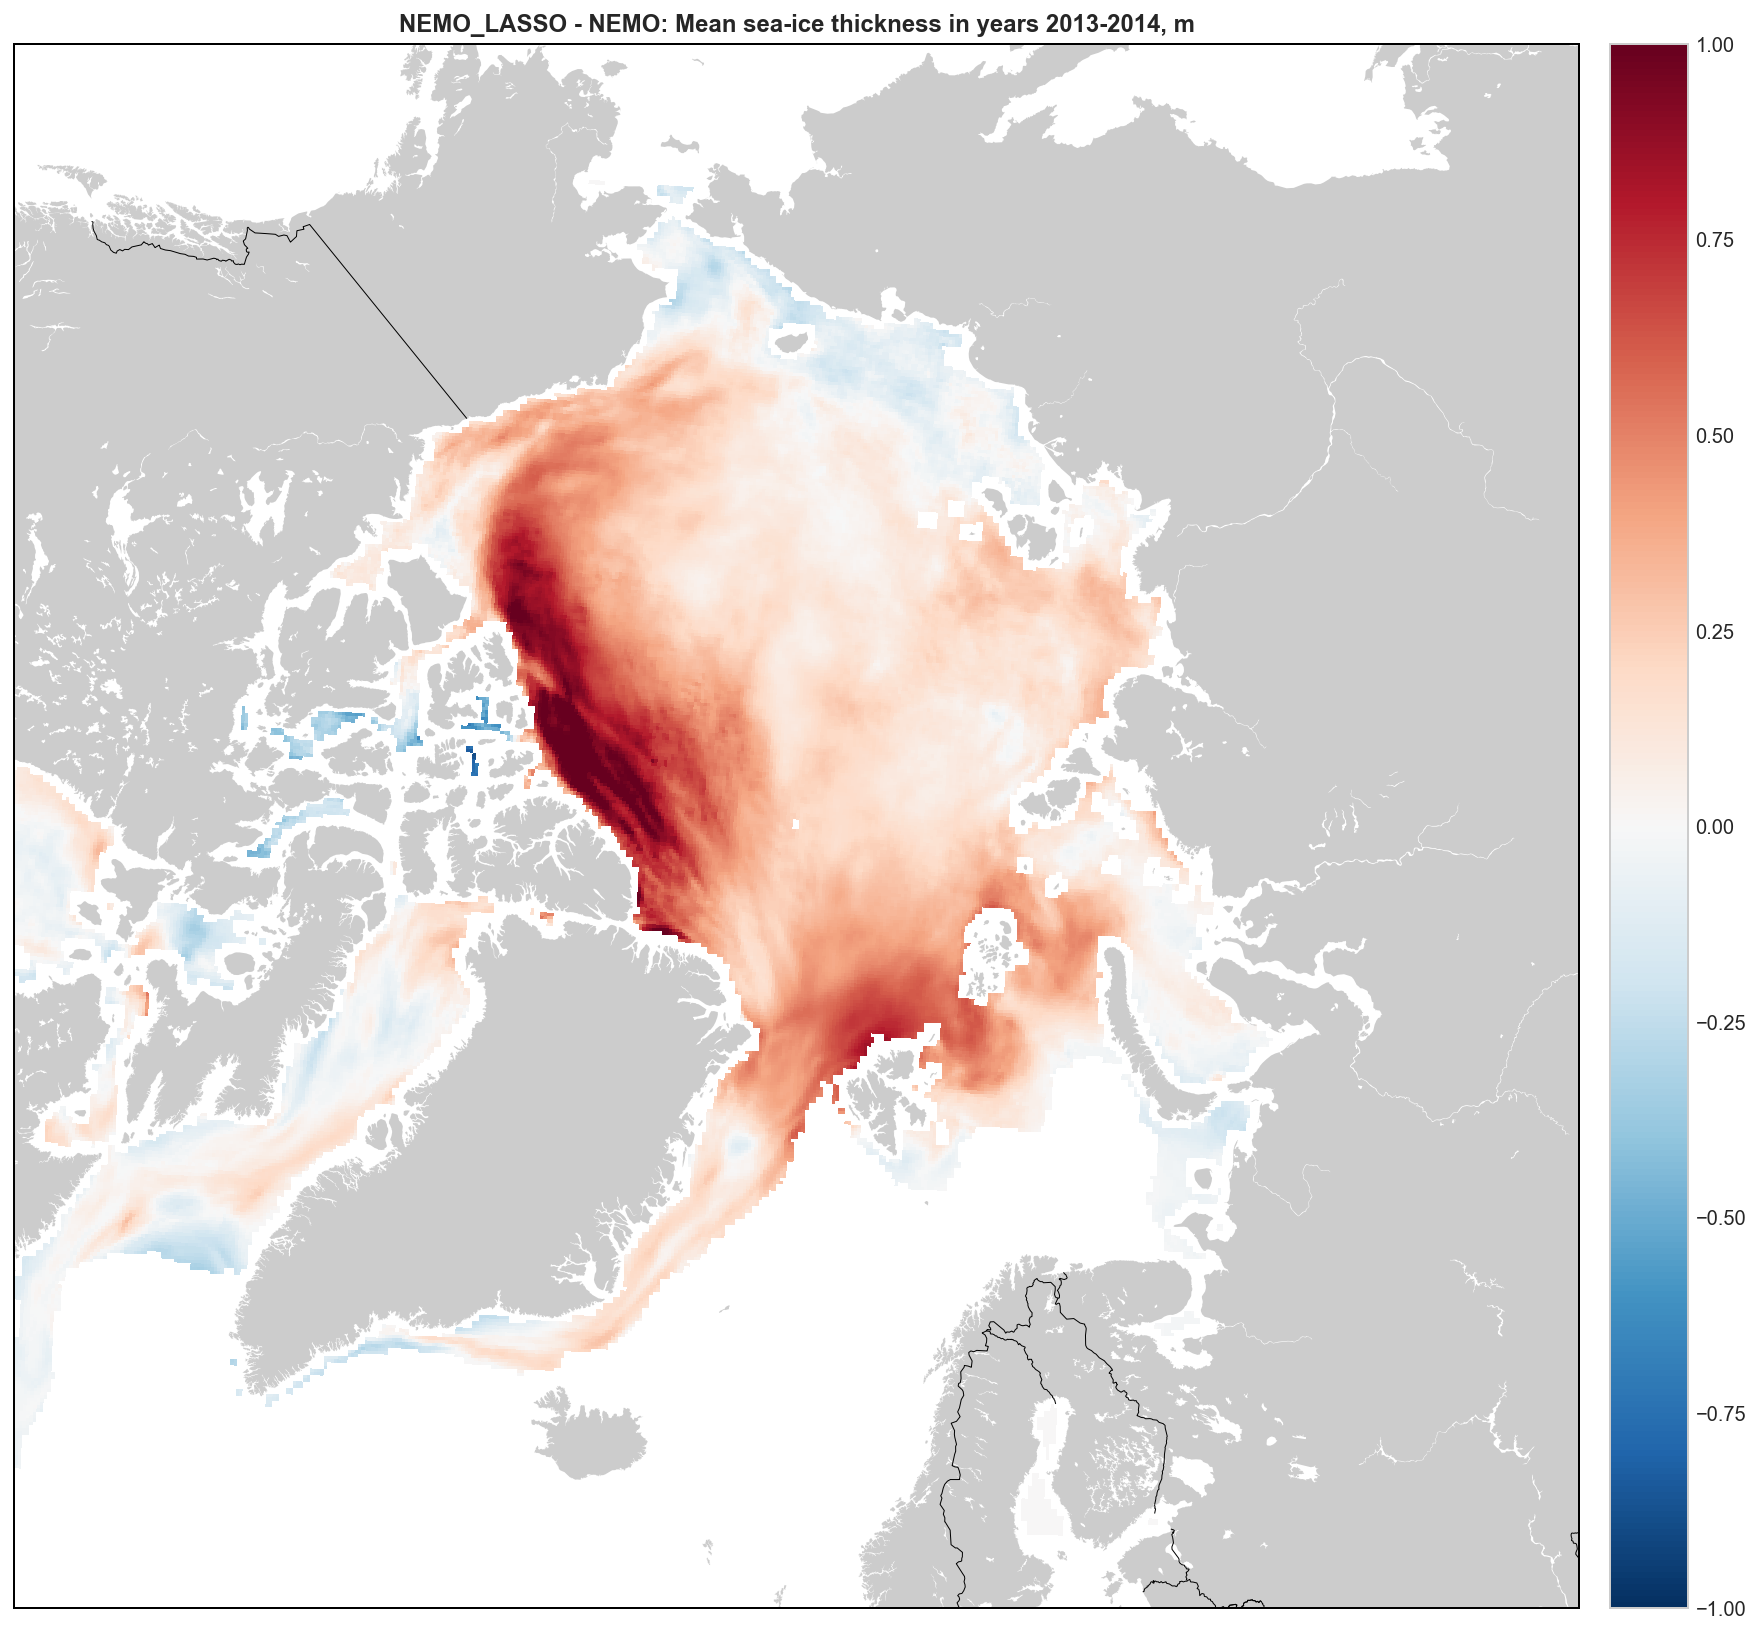

In [18]:
plot_map(np.nanmean(NEMO_LASSO-NEMO, axis=0),vmin=-1, vmax=1)
plt.title('NEMO_LASSO - NEMO: Mean sea-ice thickness in years 2013-2014, m', weight='bold')

In [ ]:
plot_map(np.nanmean(ice_sat, axis=0), vmin=0, vmax=4)
plt.title('Sattelite observations: Mean sea-ice thickness in years 2014-2015, m',weight='bold')

In [19]:
def rmse(a1, a2):
    return (np.nanmean(np.power(a1-a2, 2)))

def MAE(a1, a2):
    return np.nanmean(abs(a1-a2))

def iter_time(func ,arr_1, arr_2):
    out_array=[]
    for t in range(arr_1.shape[0]):
        out_array.append(func(arr_1[t,:,:], arr_2[t,:,:]))
    return out_array

rmse_NEMO_sat = iter_time(rmse, NEMO, ice_sat)
rmse_NEMO_LASSO_sat = iter_time(rmse, NEMO_LASSO, ice_sat)

rmse_NEMO_LASSO_TOPAZ = iter_time(rmse, NEMO_LASSO, TOPAZ)
rmse_NEMO_TOPAZ = iter_time(rmse, NEMO, TOPAZ)

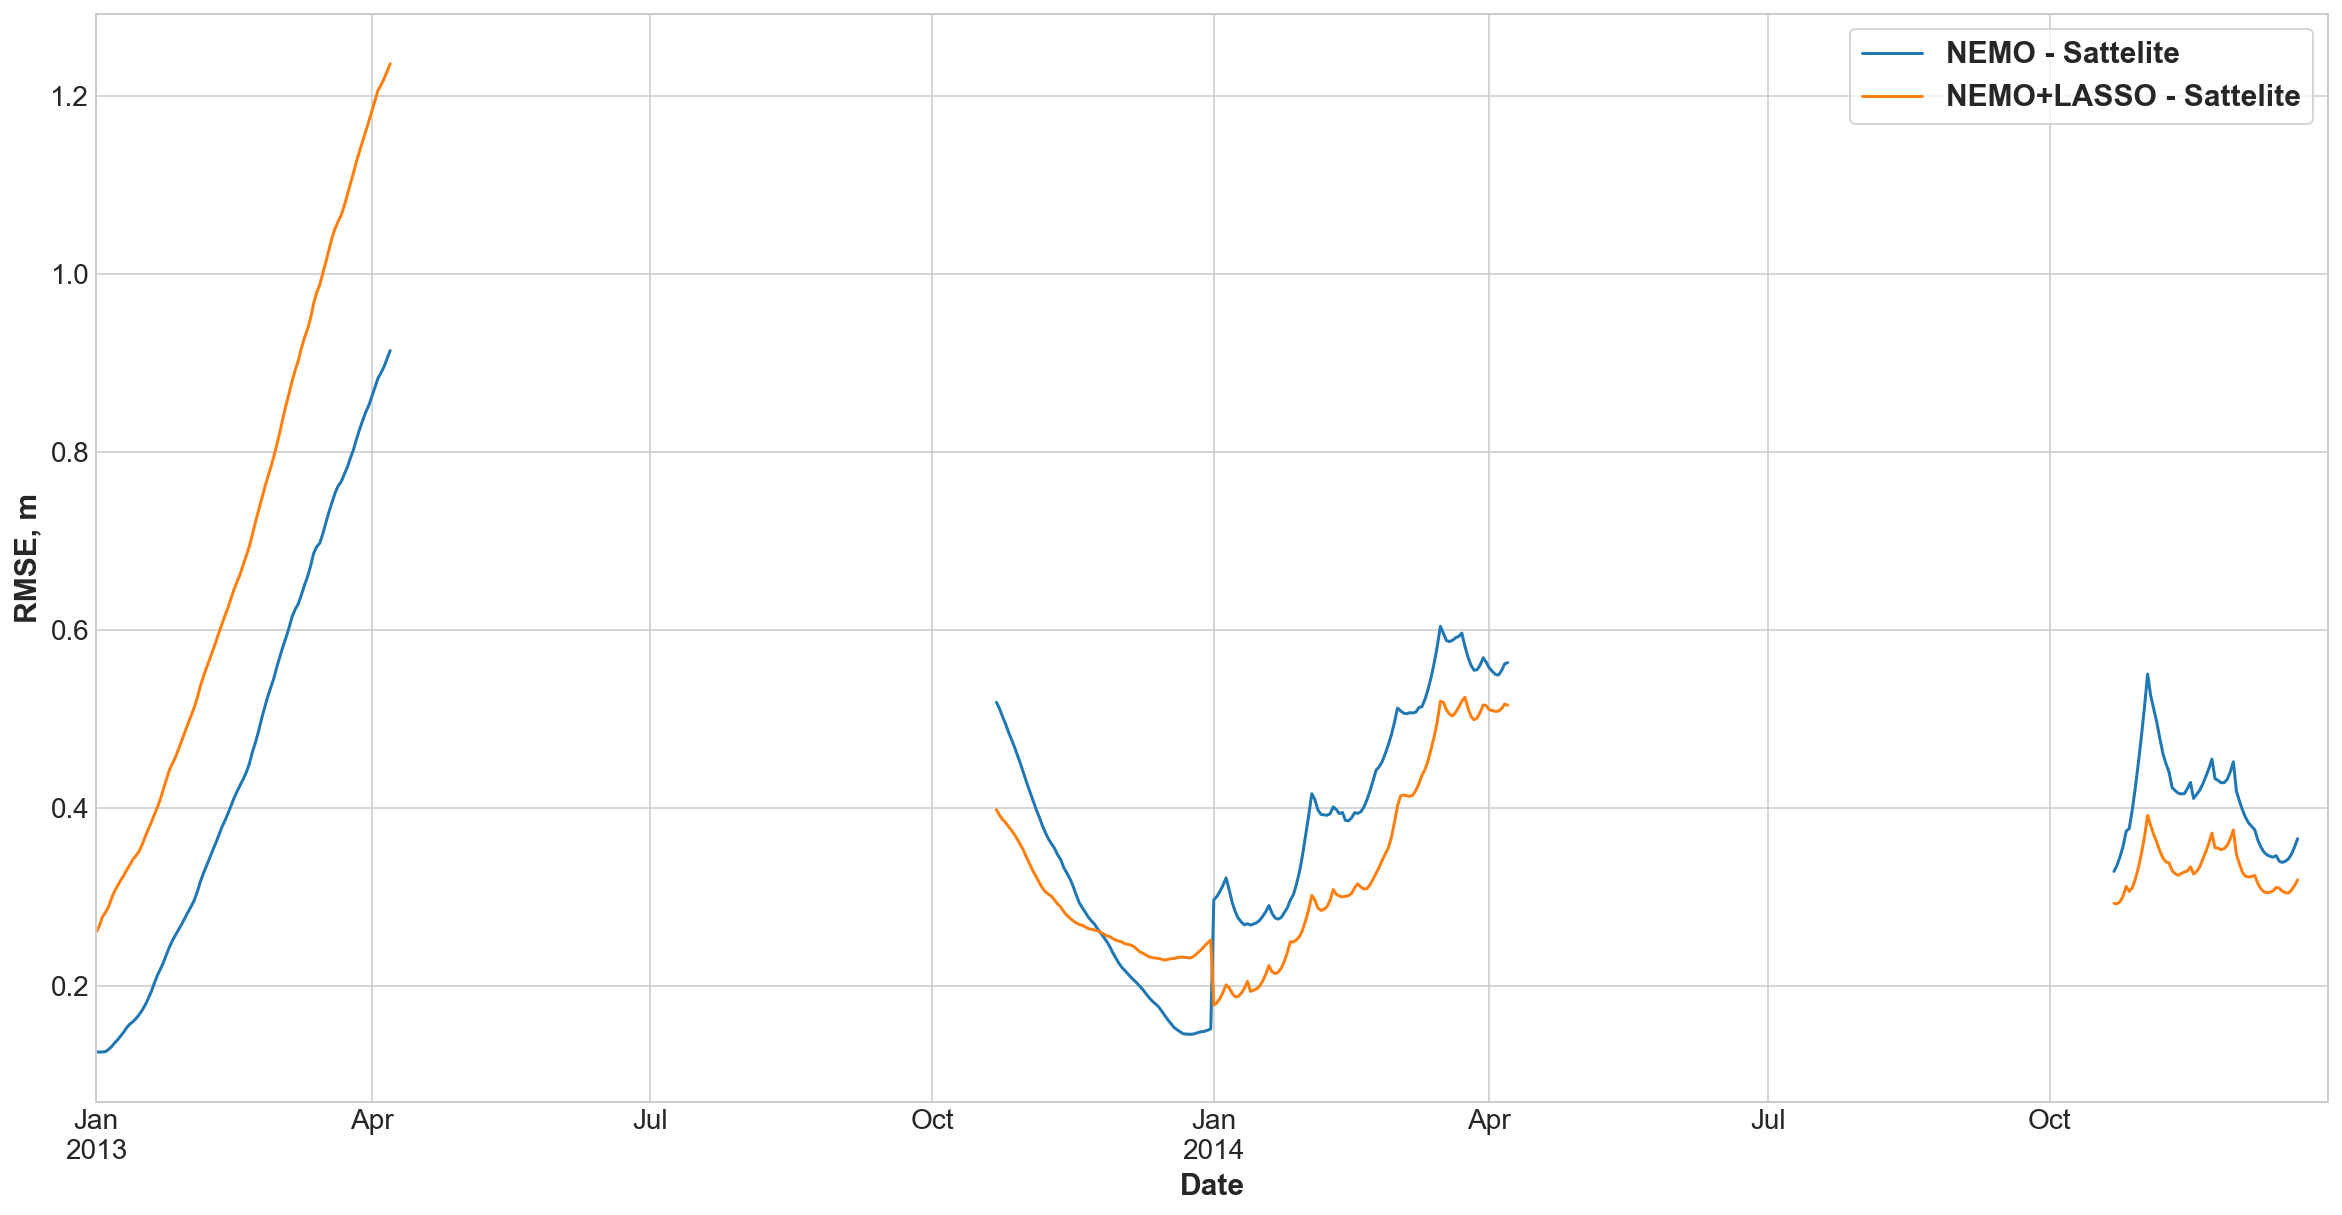

In [35]:
from scipy import stats
plt.rcParams['figure.figsize'] = [20, 10]
rmse_df = pd.DataFrame({'NEMO - Sattelite':rmse_NEMO_sat,
                        'NEMO+LASSO - Sattelite':rmse_NEMO_LASSO_sat,
                       }, index=dates)

#rmse_df['DD Model - Sattelite'][rmse_df['DD Model - Sattelite']>1]=np.nan
rmse_df[['NEMO - Sattelite','NEMO+LASSO - Sattelite']].plot()

axes = plt.gca()
#axes.set_ylim([0.2,0.8])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Date',fontsize = 15, weight = 'bold')
plt.ylabel('RMSE, m',fontsize = 15, weight = 'bold')
plt.legend(loc=1, prop={'size': 15,'weight':'bold'}, frameon=True)

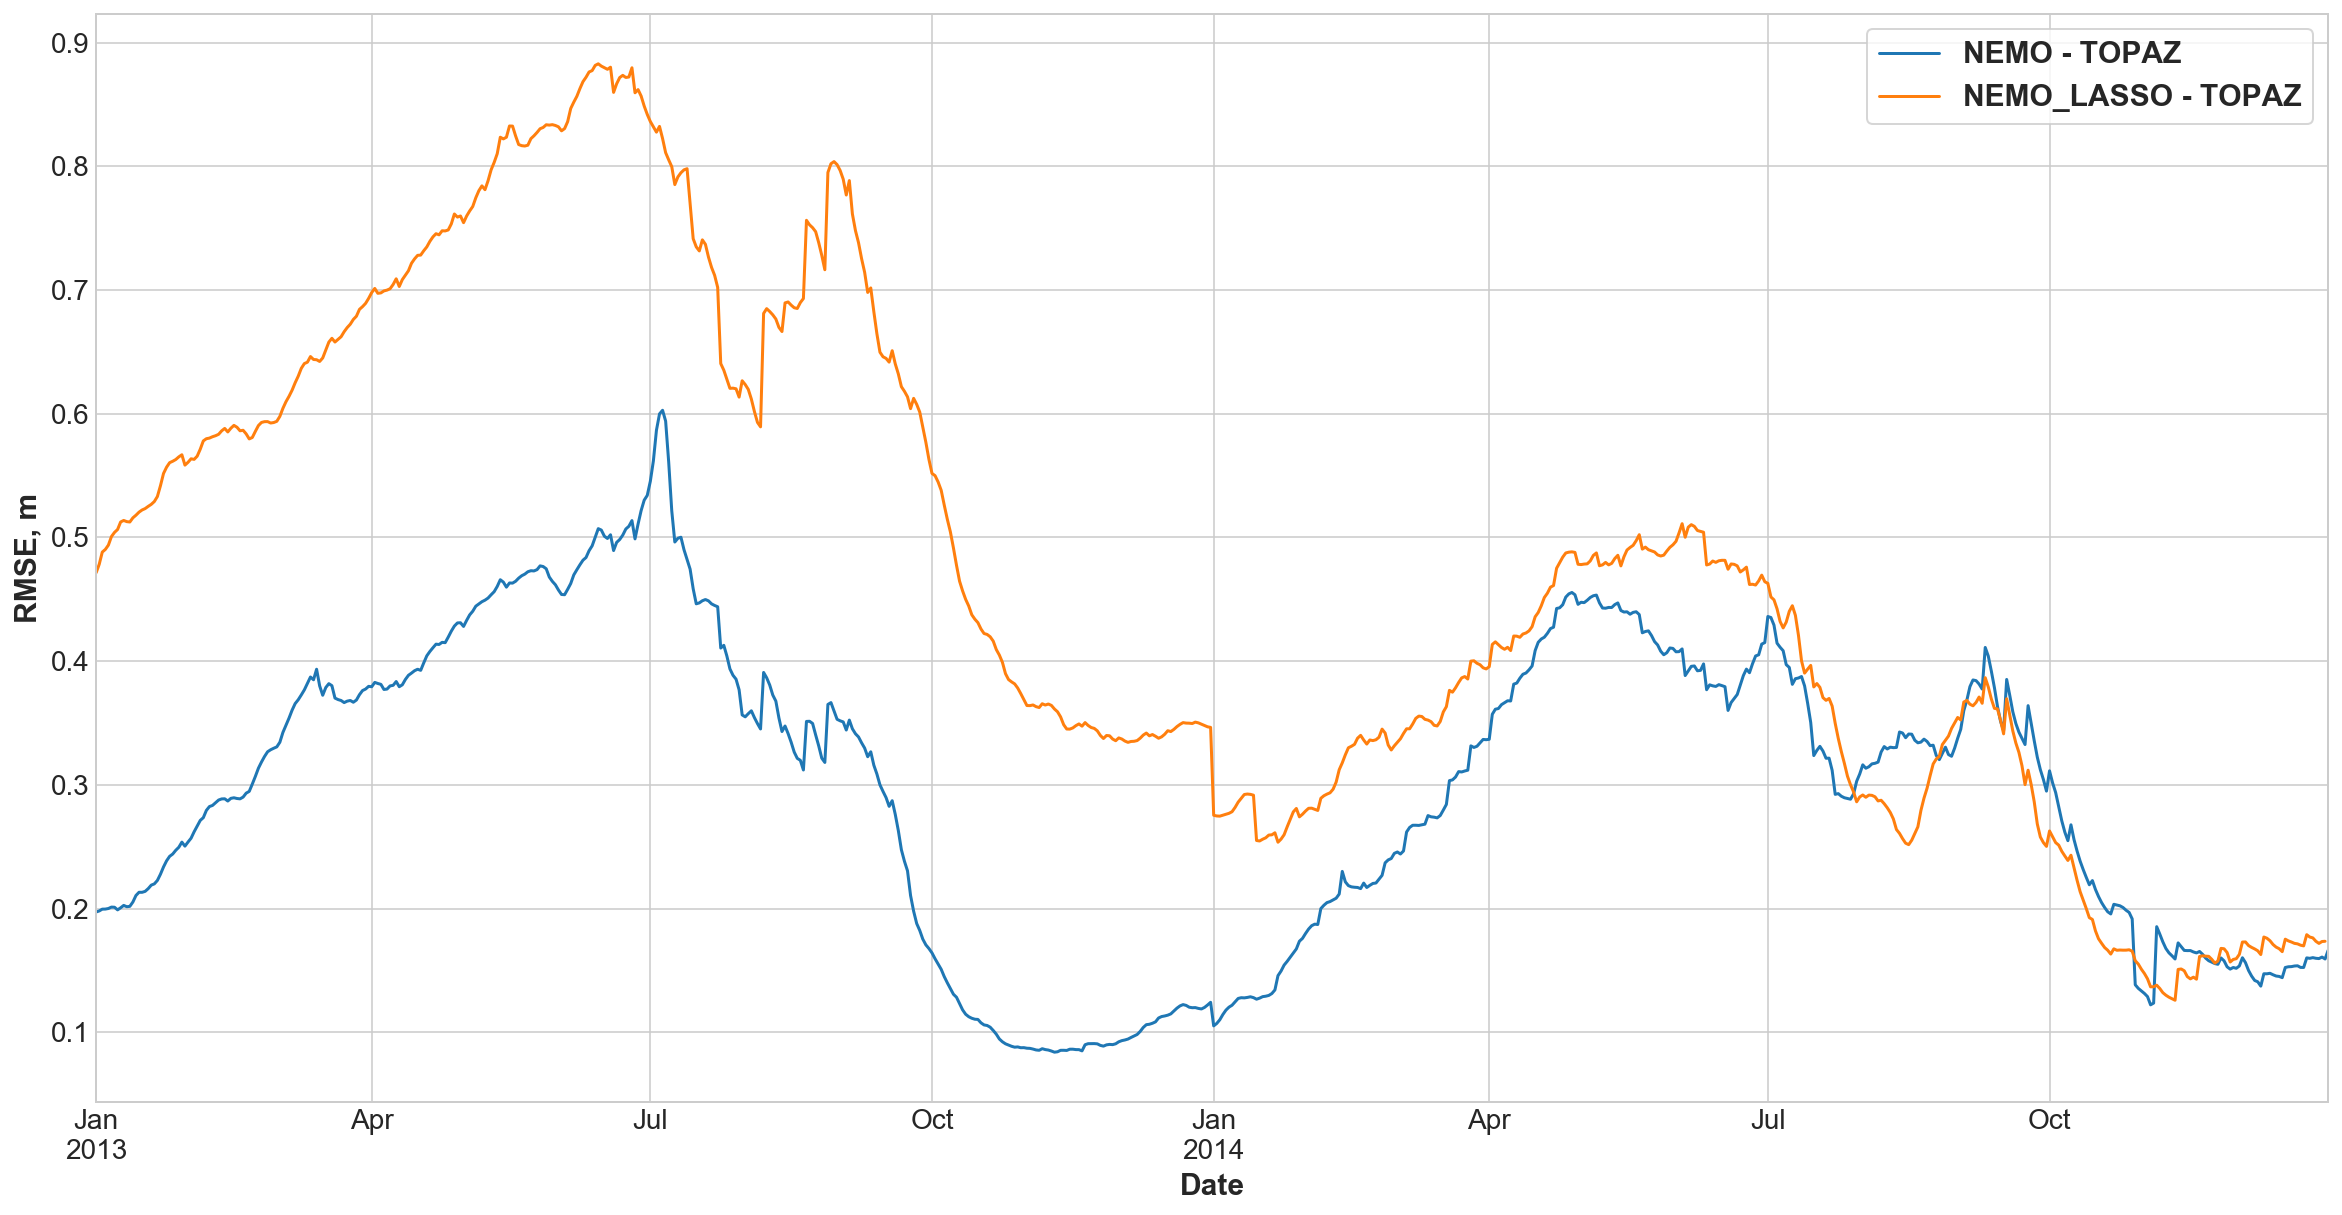

In [36]:
plt.rcParams['figure.figsize'] = [20, 10]
rmse_df = pd.DataFrame({'NEMO - TOPAZ':rmse_NEMO_TOPAZ,
                        'NEMO_LASSO - TOPAZ':rmse_NEMO_LASSO_TOPAZ,
                       }, index=dates)

#rmse_df['DD Model - Sattelite'][rmse_df['DD Model - Sattelite']>1]=np.nan
rmse_df[['NEMO - TOPAZ','NEMO_LASSO - TOPAZ']].plot()

axes = plt.gca()
#axes.set_ylim([0.2,0.8])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Date',fontsize = 15, weight = 'bold')
plt.ylabel('RMSE, m',fontsize = 15, weight = 'bold')
plt.legend(loc=1, prop={'size': 15,'weight':'bold'}, frameon=True)

In [22]:
plt.rcParams['figure.figsize'] = [20, 10]
mae_df = pd.DataFrame({'NEMO - Sattelite':mae_NEMO_sat,
                       'DD Model - Sattelite':mae_prediction_sat,
                       'DD Model - NEMO':mae_prediction_nemo}, index=dates)

#mae_df['DD Model - Sattelite'][mae_df['DD Model - Sattelite']>1]=np.nan
mae_df[['NEMO - Sattelite','DD Model - Sattelite']].plot()

axes = plt.gca()
axes.set_ylim([0.2,0.8])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Date',fontsize = 15, weight = 'bold')
plt.ylabel('MAE, m',fontsize = 15, weight = 'bold')
plt.legend(loc=1, prop={'size': 15,'weight':'bold'}, frameon=True)

NameError: name 'mae_NEMO_sat' is not defined

In [25]:
def rmse3d(a1,a2):
    return np.nanmean(np.power(a1-a2, 2), axis=0)
def MAE3d(a1,a2):
    return np.nanmean(abs(a1-a2), axis=0)

### plot_map(rmse3d(ice_sat, NEMO_LASSO), vmin=0, vmax=2)
plt.title('Root mean square error of sea-ice thickness 2013-2014, m',  weight = 'bold')

Text(0.5, 1.0, 'Root mean square error of sea-ice thickness 2013-2014, m')

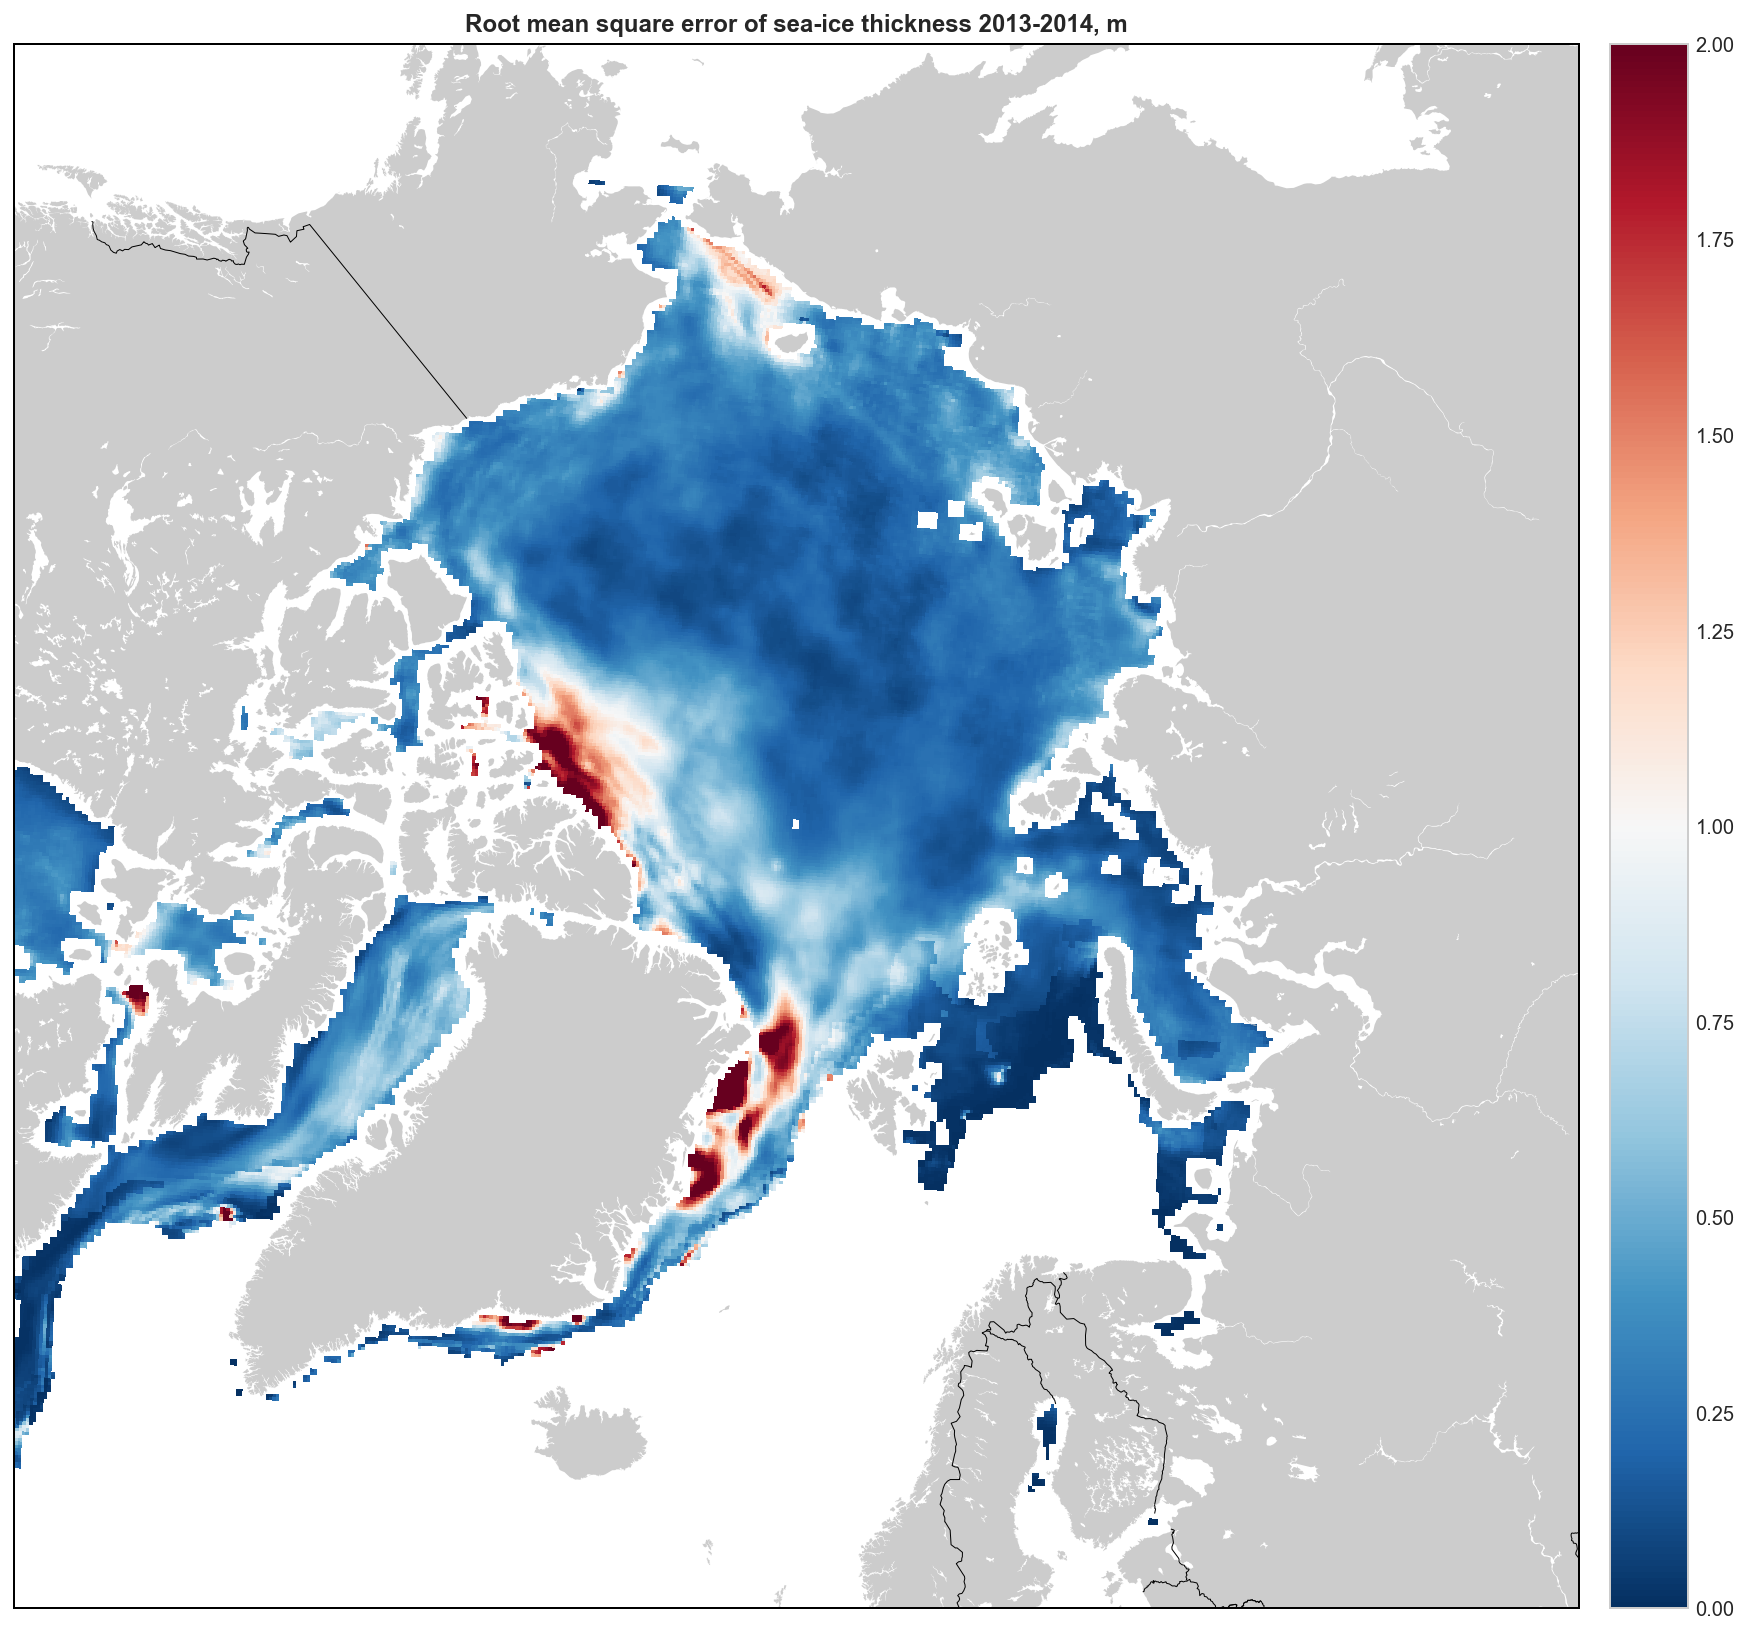

In [51]:
plot_map(rmse3d(ice_sat, NEMO),vmin=0, vmax=2)
plt.title('Root mean square error of sea-ice thickness 2013-2014, m',  weight = 'bold')

Text(0.5, 1.0, 'Mean absolute error of sea-ice thickness 2014-2015, m')

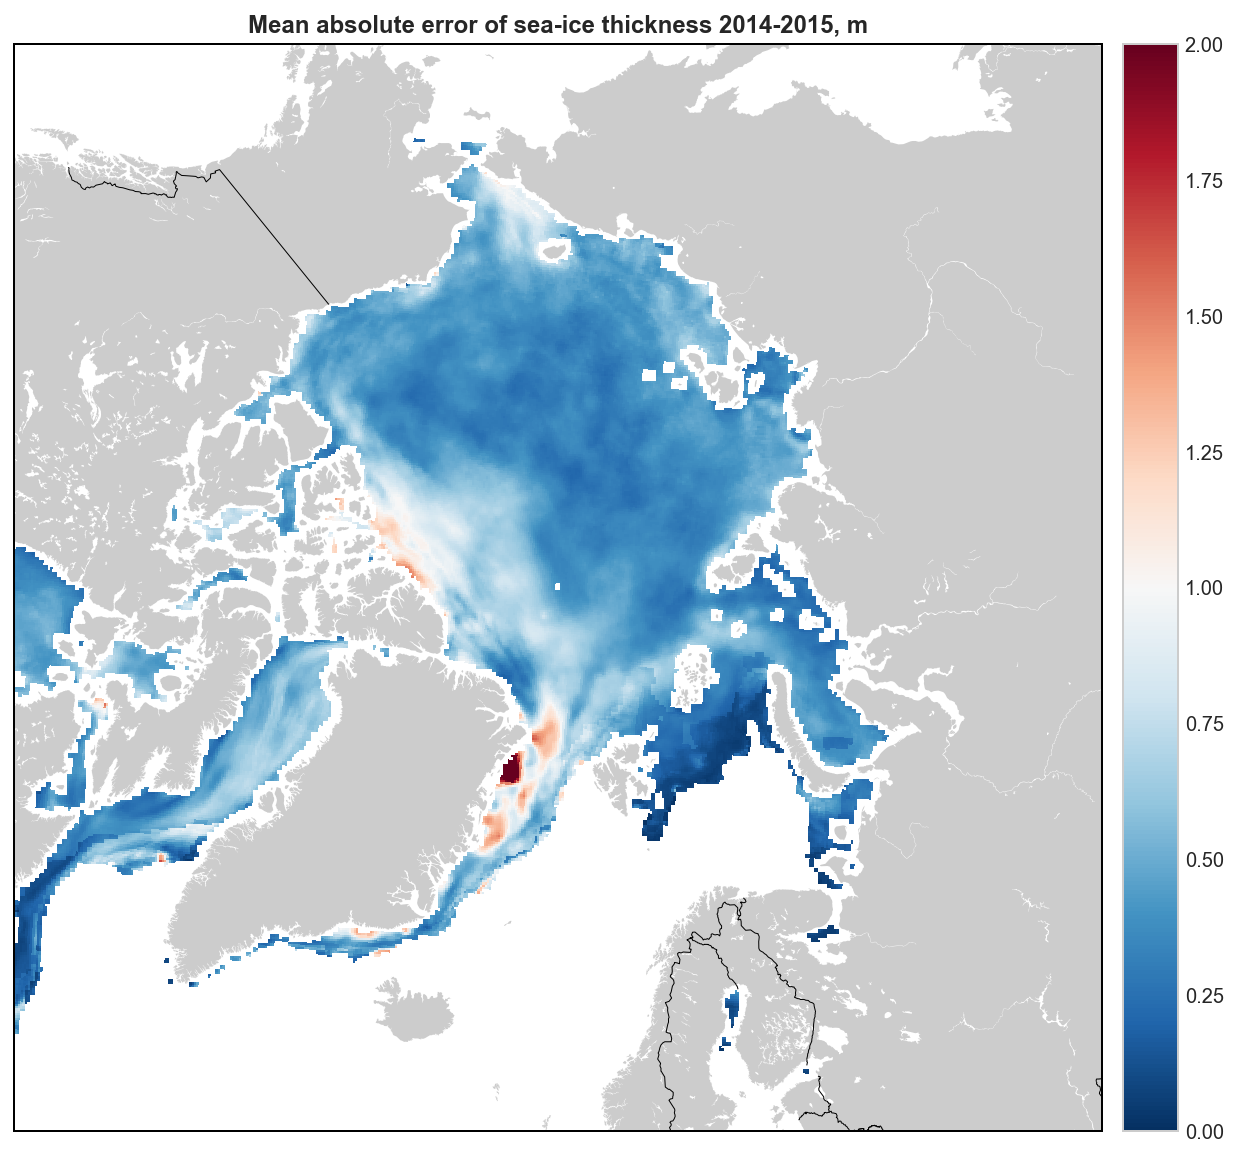

In [29]:
plot_map(MAE3d(ice_sat, NEMO), vmin=0, vmax=2)
plt.title('Mean absolute error of sea-ice thickness 2014-2015, m',  weight = 'bold')

Text(0.5, 1.0, 'Mean absolute error of sea-ice thickness 2013-2014, m')

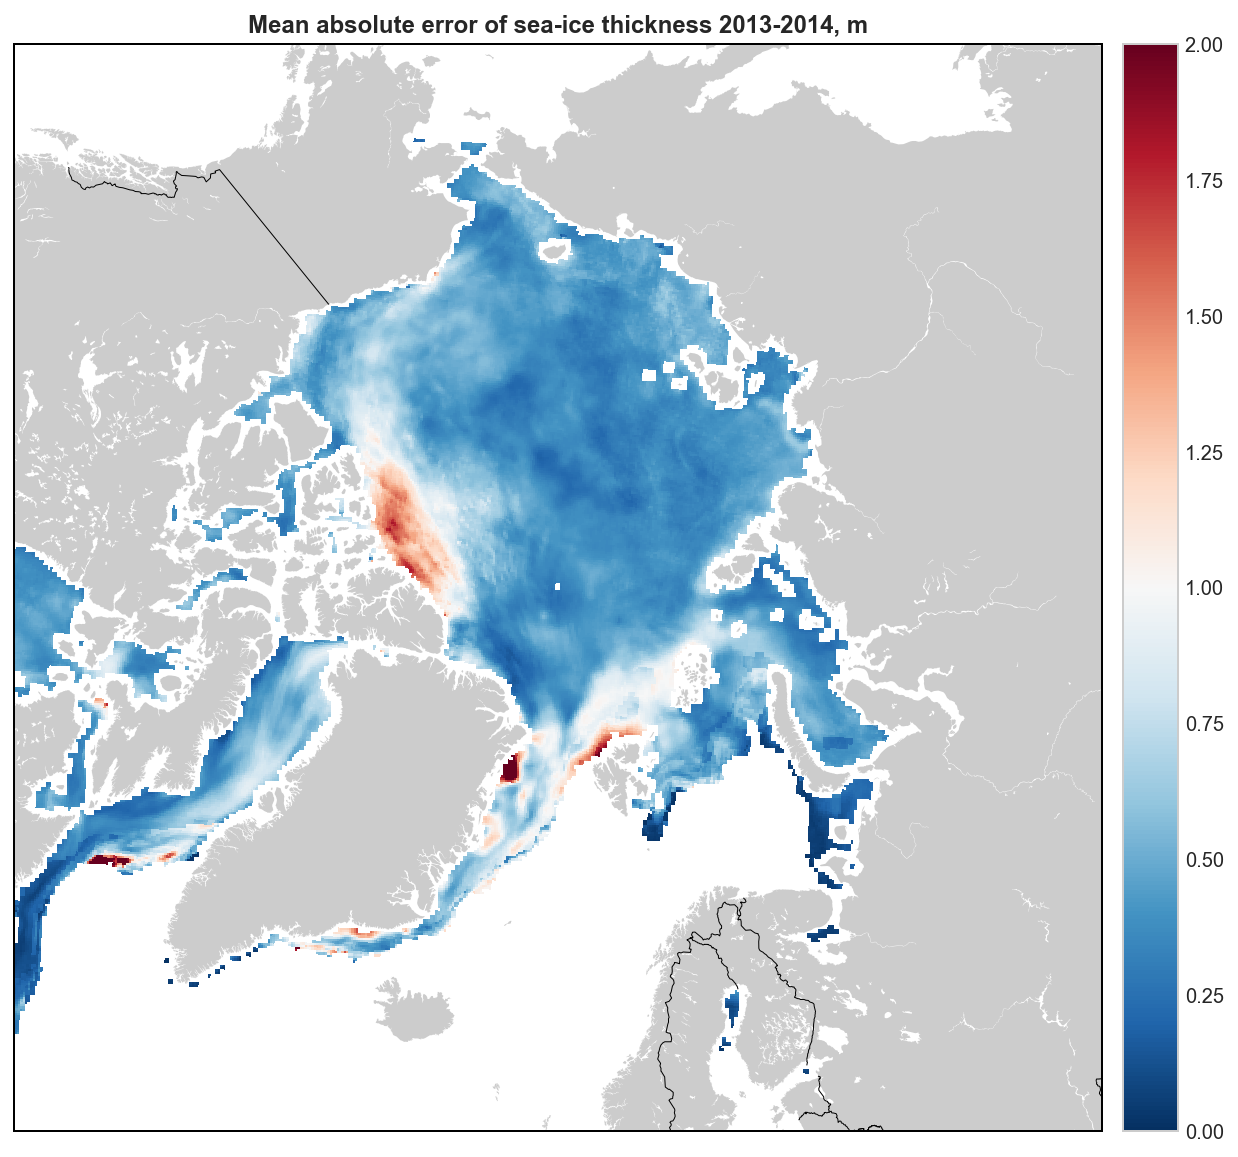

In [39]:
plot_map(MAE3d(ice_sat, NEMO_LASSO), vmin=0, vmax=2)
plt.title('Mean absolute error of sea-ice thickness 2013-2014, m',  weight = 'bold')

409.06918
0.0


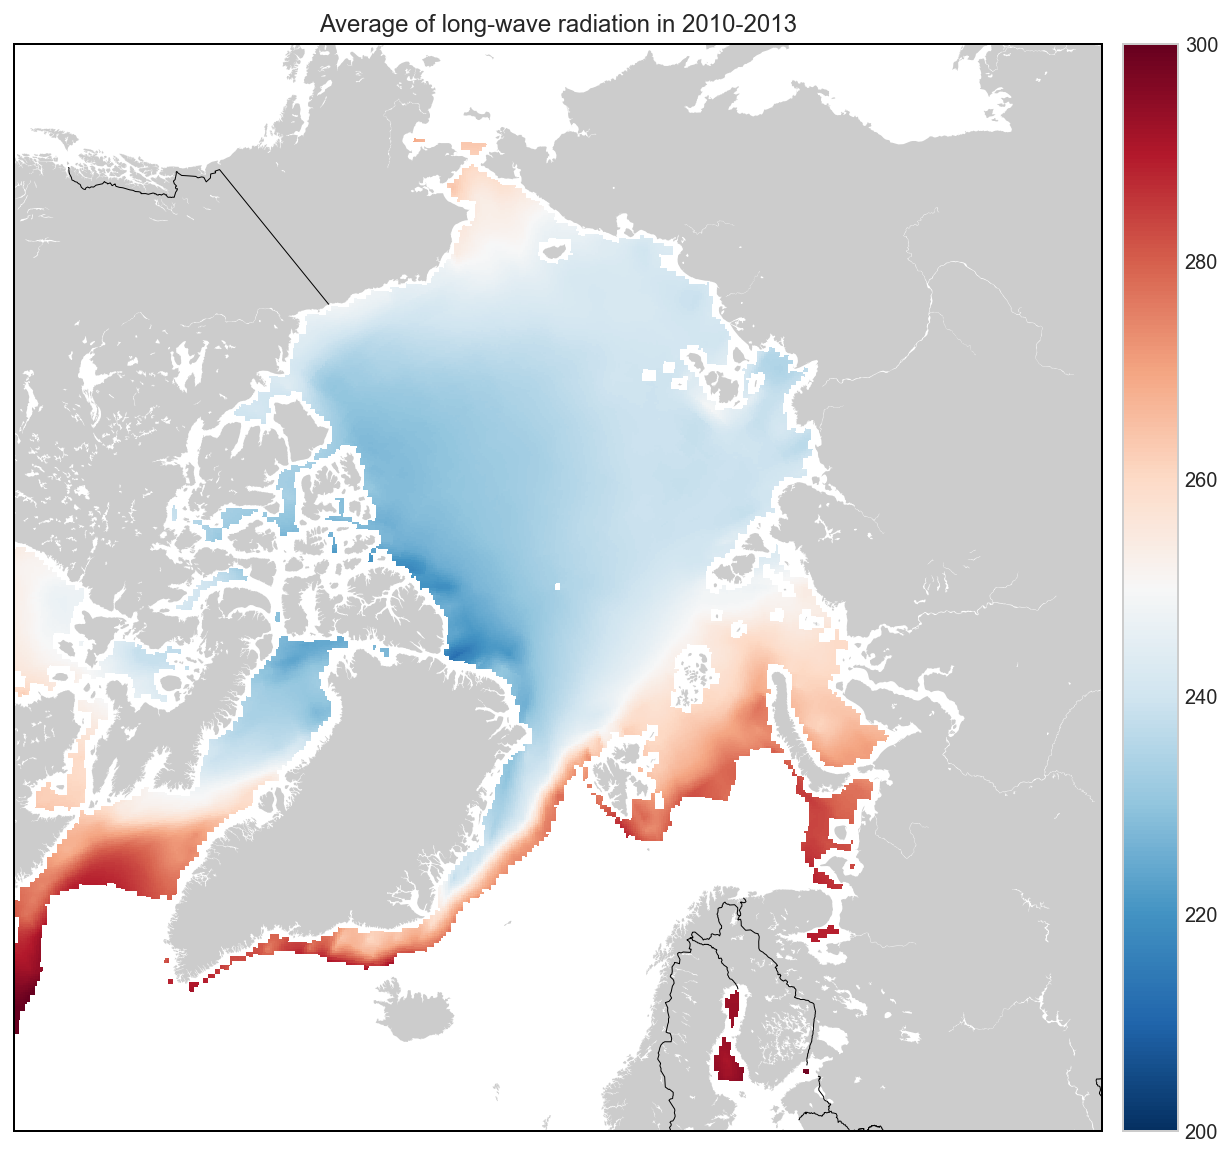

In [37]:
X_vars_names=['sattelite-measured sea ice concentration','NEMO sea ice thickness', 'air temperature','NEMO surface salinity','long-wave radiation']
X_vars=['ice_conc','icethic_cea', 'tair','vosaline','radlw']

i=4
_ = data.load_variable_years(X_vars[i],list(range(2010, 2014)))
_ = apply2dmask(_, ice_line)
avg = np.nanmean(_, axis=0)
print(np.nanmax(_))
print(np.nanmin(_))

plot_map(avg, vmin=200, vmax=300)
plt.title(f'Average of {X_vars_names[i]} in 2010-2013')
plt.show()

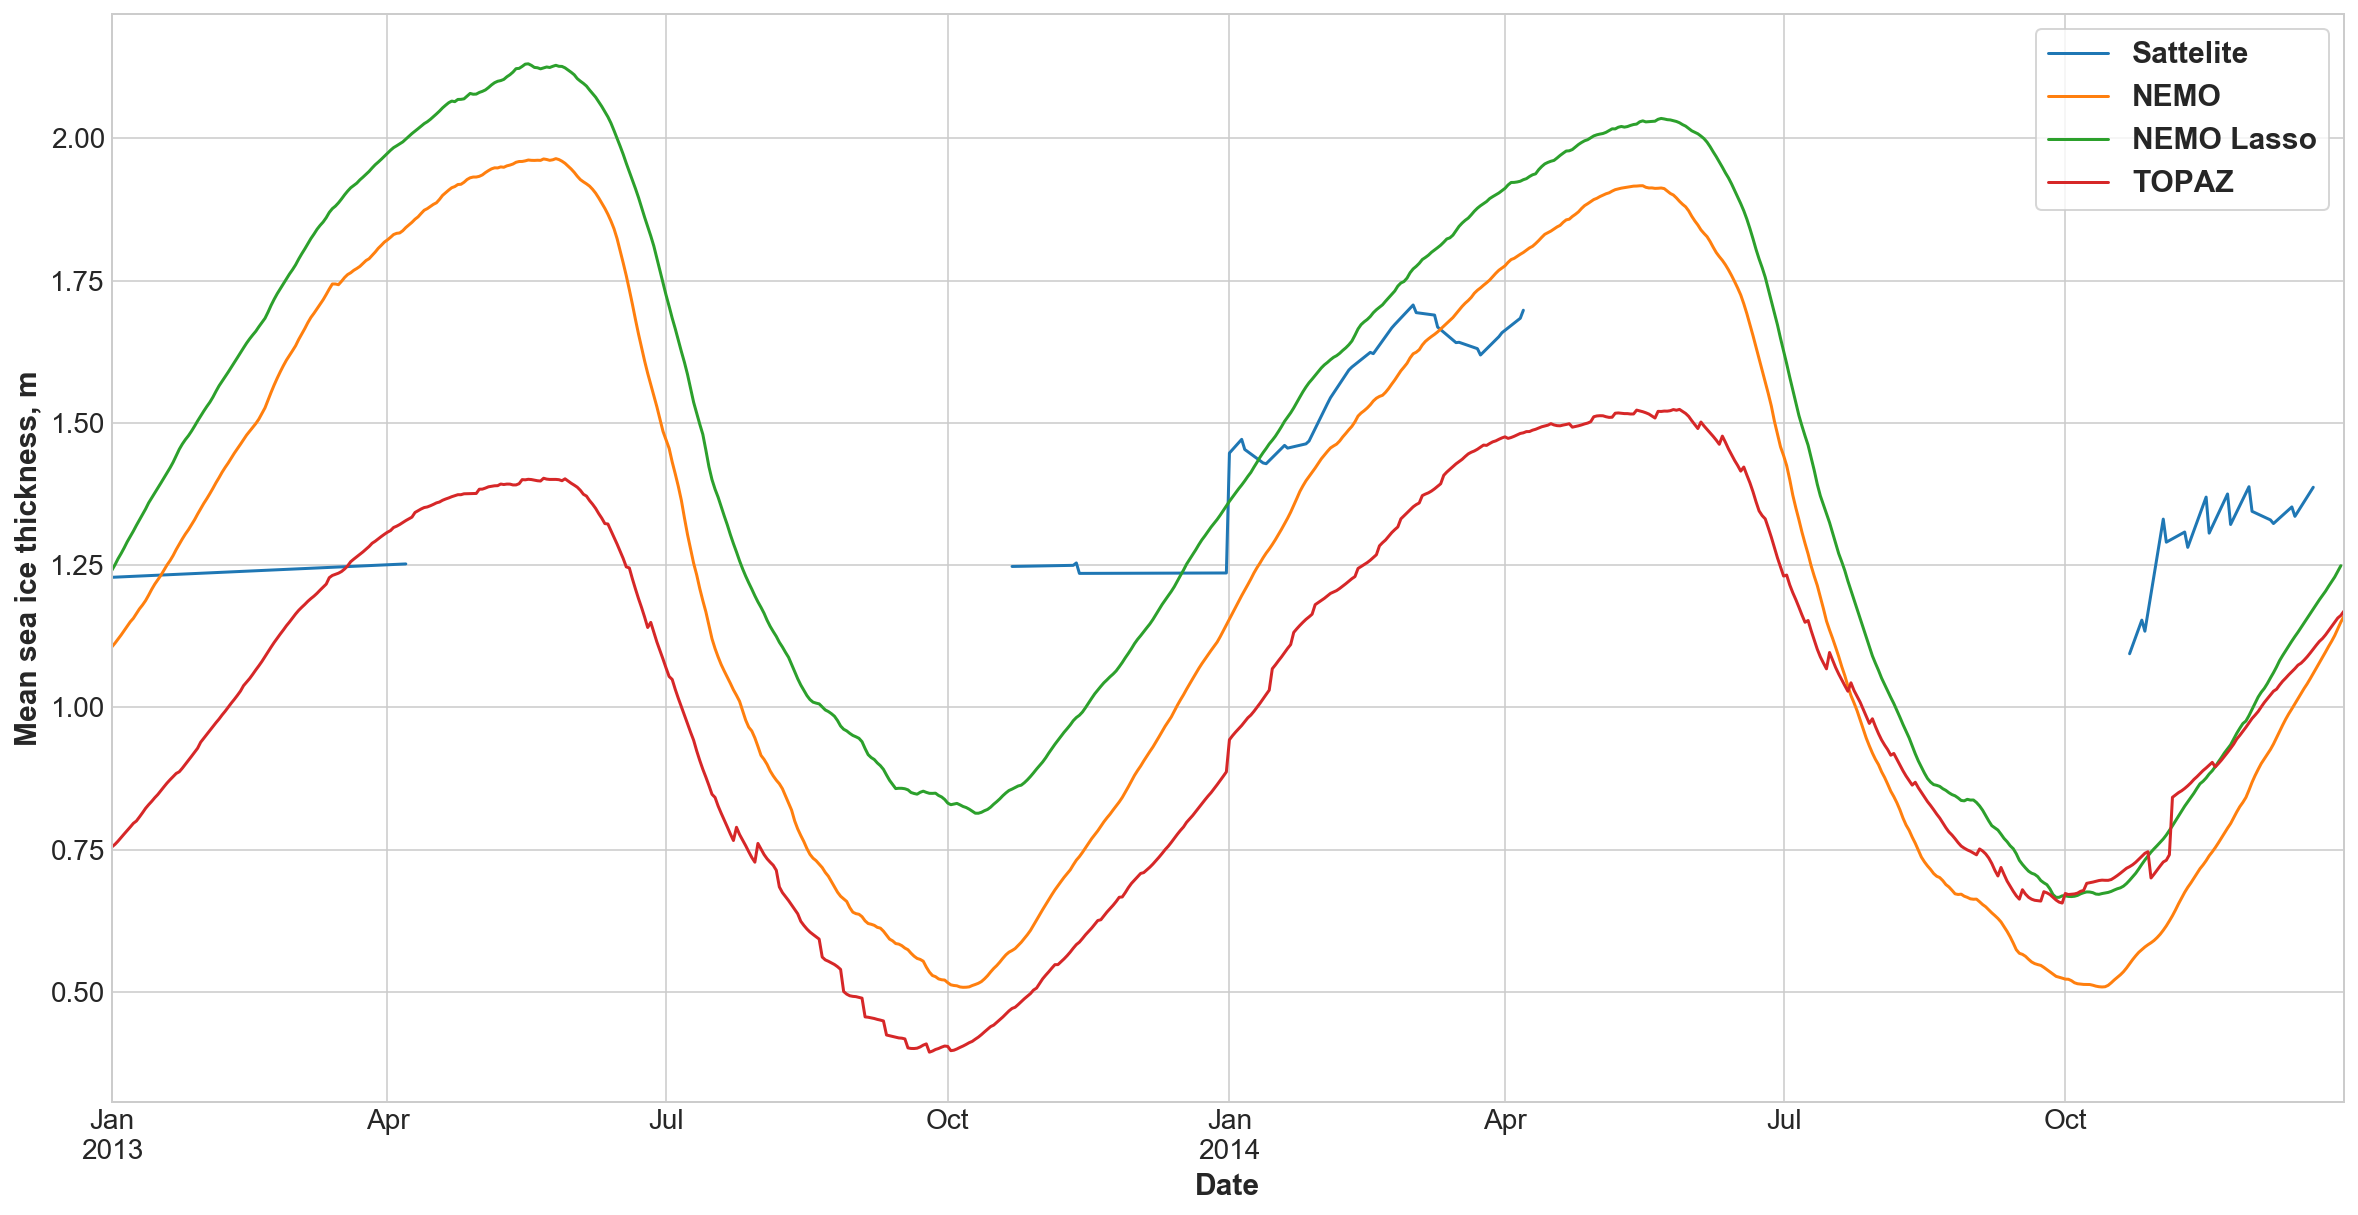

In [38]:
mean_dd = []
mean_sat = []
mean_nemo = []
mean_nemo_lasso = []
mean_topaz = []

for t in range(NEMO.shape[0]):
    #mean_dd.append(np.nanmean(res[t,:,:]))
    mean_sat.append(np.nanmean(ice_sat[t,:,:]))
    mean_nemo.append(np.nanmean(NEMO[t,:,:]))
    mean_nemo_lasso.append(np.nanmean(NEMO_LASSO[t,:,:]))
    mean_topaz.append(np.nanmean(TOPAZ[t,:,:]))
    
plt.rcParams['figure.figsize'] = [20, 10]
mean_df = pd.DataFrame({#'DD Model':mean_dd,
                       'Sattelite':mean_sat,
                       'NEMO':mean_nemo,
                       'NEMO Lasso':mean_nemo_lasso,
                       'TOPAZ':mean_topaz}, index=dates)

mean_df[mean_df==0] = np.nan
mean_df.plot()

axes = plt.gca()
#axes.set_ylim([0.2,0.8])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Date',fontsize = 15, weight = 'bold')
plt.ylabel('Mean sea ice thickness, m',fontsize = 15, weight = 'bold')
plt.legend(loc=1, prop={'size': 15,'weight':'bold'}, frameon=True)